# [COM6513] Assignment 2: Topic Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward neural network for topic classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)


- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)


- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**3 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**6 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**2 marks**)



- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500}, the dropout rate {e.g. 0.2, 0.5} and the learning rate. Please use tables or graphs to show training and validation performance for each hyperparameter combination  (**2 marks**). 



- After training a model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy. Does your model overfit, underfit or is about right? (**1 mark**).



- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**3 marks**).



- Extend you Feedforward network by adding more hidden layers (e.g. one more or two). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**4 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices (**2 marks**). 



- Provide efficient solutions by using Numpy arrays when possible. Executing the whole notebook with your code should not take more than 10 minutes on any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs and loading the pretrained vectors. You can find tips in Lab 1 (**2 marks**). 



### Data 

The data you will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You should submit a Jupyter Notebook file (assignment2.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).


You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/3/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are **not allowed to use any third-party library** such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras, Pytorch etc.. You should mention if you've used Windows to write and test your code because we mostly use Unix based machines for marking (e.g. Ubuntu, MacOS). 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 30. It is worth 30\% of your final grade in the module.

The deadline for this assignment is **23:59 on Mon, 9 May 2022** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [5]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [6]:
train_data = pd.read_csv("data_topic/train.csv", header=None)
val_data = pd.read_csv("data_topic/dev.csv", header=None)
test_data = pd.read_csv("data_topic/test.csv", header=None)

In [7]:
train_data[1][1]

'Reuters - South Korean police used water cannon in\\central Seoul Sunday to disperse at least 7,000 protesters\\urging the government to reverse a controversial decision to\\send more troops to Iraq.'

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [682]:
# A few more words have been added in the given list
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its', 's',
              'about', 'above', 'after', 'again', 'all', 'also', 'am', 'any', "aren", "t", 
               'because', 'before', 'being', 'below', 'between', 'both', 'but', 'cannot', 
               'does', 'down', 'during', 'each', 'don', 'doing'
               'else', 'ever', 'few', 'further', 'get', 'had', 'having',
               "d", "ll", 'here', 'hers', 'herself', 'him', 'himself', 'how', 
               'however', "m", "ve", 'if', 'into', "isn", 'itself', 'just',
               "let", 'me', 'more', 'most', "mustn", 'my', 'myself', 'no', 'nor', 'not', 'off', 
               'once', 'only', 'other', 'otherwise', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 
               'same', 'shall', "shan", 'should', "shouldn",'since', 'so', 
               'some', 'such', 'than', 'their', 'theirs', 'themselves', 'then', 'there', "couldn", 'doesn', 'hadn', 'haven' 
                "re", 'through', 'too', 'under', 'until', 'up', 'very', 
               "wasn", "weren", 'when', 'where',
               'while', 'whom', 'why', "won", 'would', "wouldn", 
               'your', 'yours', 'yourself', 'yourselves', '']


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [828]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'[^A-Za-z]+', 
                   stop_words=[], vocab=set()):
    
    x = []
    
    tokenize = re.compile(token_pattern)
    words = tokenize.split(x_raw.lower()) 
    
    uni_gram = [word for word in words if word not in stop_words]
            
    # Getting n-grams 
    for n in range(ngram_range[0], ngram_range[1]+1):    
        if n == 1:
            x = x + uni_gram   
        else:
            for i in range(len(uni_gram)-n+1):
                ngram = tuple(uni_gram[i:i+n])
                x.append(ngram)
    
      
    # Use vocab only if its not empty
    if len(vocab) != 0:
        x = [word for word in x if word in vocab]
        
    return x

In [830]:
#As for this particular task we are only working with unigrams hence range is (1,1)
x = extract_ngrams(train_data[1][1], ngram_range=(1,1), stop_words = stop_words)
x

['reuters',
 'south',
 'korean',
 'police',
 'used',
 'water',
 'cannon',
 'central',
 'seoul',
 'sunday',
 'disperse',
 'least',
 'protesters',
 'urging',
 'government',
 'reverse',
 'controversial',
 'decision',
 'send',
 'troops',
 'iraq']

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [877]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'[^A-Za-z]+', 
              min_df=0, keep_topN=0, 
              stop_words=[]):
    
    df = Counter()
    ngram_counts = Counter()
    vocab = set()
    for text in X_raw:
        text_ngrams = extract_ngrams(text,
                       ngram_range=ngram_range,
                       stop_words=stop_words,)
        
        df.update(list(set(text_ngrams)))
        ngram_counts.update(text_ngrams)
        
    vocab = set([w for w in df if df[w]>=min_df])
    
    if keep_topN>0:
        vocab = set([w[0] for w in ngram_counts.most_common(keep_topN) if w[0] in vocab])
    
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [1210]:
%%time
# We have not given any min_df or keep_topN values as the model was performing the best with these conditions 
vocab,doc_freq,ngram_count = get_vocab(train_data[1],
                                       ngram_range=(1,1),
                                      stop_words = stop_words,
                                      min_df = 0,
                                      keep_topN = 0)

CPU times: user 153 ms, sys: 8.55 ms, total: 161 ms
Wall time: 167 ms


Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [1211]:
vocab_id2word = dict(enumerate(vocab))
vocab_word2id = dict((v,k) for k,v in vocab_id2word.items())

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [1212]:
def convert_into_unigram(raw_texts, vocab):
    text_ngram_list = []
    for text in raw_texts:
        text_ngram = extract_ngrams(text, 
                                    ngram_range = (1,1),
                                    stop_words = stop_words,
                                    vocab = vocab)
        text_ngram_list.append(text_ngram)
    return text_ngram_list


#converting all the datasets into list of unigrams
train_docs = convert_into_unigram(train_data[1], vocab = vocab)
val_docs = convert_into_unigram(val_data[1], vocab = vocab)
test_docs = convert_into_unigram(test_data[1], vocab = vocab)

train_docs[1]

['reuters',
 'south',
 'korean',
 'police',
 'used',
 'water',
 'cannon',
 'central',
 'seoul',
 'sunday',
 'disperse',
 'least',
 'protesters',
 'urging',
 'government',
 'reverse',
 'controversial',
 'decision',
 'send',
 'troops',
 'iraq']

Then convert them into lists of indices in the vocabulary:

In [1213]:
#function to convert the textx into list of indices for words in vocabulary
def to_indices(docs):
    docs_idx_list = []
    for doc in docs:
        idx = []
        for w in doc:
            idx.append(vocab_word2id[w])
        docs_idx_list.append(idx)
    return docs_idx_list


#getting list of indices for all datasets 
train_idx = to_indices(train_docs)
val_idx = to_indices(val_docs)
test_idx = to_indices(test_docs)

Put the labels `Y` for train, dev and test sets into arrays: 

In [1214]:
train_labels = train_data[0].to_numpy()
val_labels = val_data[0].to_numpy()
test_labels = test_data[0].to_numpy()


# subtract 1 from all the labels so as to start them from 0 instead of 1
# this makes sure that each index in the output list gives prediction probability for the correct class
train_true_labels = train_labels.copy()-1
val_true_labels = val_labels.copy()-1
test_true_labels = test_labels.copy()-1

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [803]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):
    
    W = {}
    n = 1
    
    W[0] = np.float32(np.random.uniform(-0.1, 0.1, (vocab_size, embedding_dim)))  # Initialiizng weight-matrix for embedding layer
    
    if len(hidden_dim) != 0:
        for dim in hidden_dim:
            W[n] = np.float32(np.random.uniform(-0.1, 0.1, (W[n-1].shape[1], dim)))   # Initializing weight-matrices for all hidden layer
            n+=1 
    
    W[n] = np.float32(np.random.uniform(-0.1, 0.1, (W[n-1].shape[1], num_classes)))   # Initializing weight-matrix for output layer
    return W
    

In [883]:
# to check the working of the above function
W1 = network_weights(vocab_size=100,embedding_dim=50, hidden_dim=[30,20,10], num_classes=3)

# print shapes of each element in W
for k,v in W1.items():
    print("Shape of ",k+1, " layer = ", v.shape)

Shape of  1  layer =  (100, 50)
Shape of  2  layer =  (50, 30)
Shape of  3  layer =  (30, 20)
Shape of  4  layer =  (20, 10)
Shape of  5  layer =  (10, 3)


Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [884]:
def softmax(z):
    
    sig = np.exp(z) / np.sum(np.exp(z))
    
    return sig

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [885]:
def categorical_loss(y, y_preds):
    
    # As the labels are generally one hot encoded
    # Only the true label would be present in the sum rest would all be zero
    # True label is y-1 because the labels in given data starts from 1
    l =  -np.log(y_preds[y-1]) 
    
    return l

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [886]:
def relu(z):
    
    a = z.copy()
    a = np.maximum(a , 0.0)
    
    return a
    
def relu_derivative(z):
    
    dz = z.copy()
    dz = np.greater(dz, 0).astype(float)
    
    return dz


During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [887]:
def dropout_mask(size, dropout_rate):
    
    vec = np.ones(size)
    drop = int(size*dropout_rate)
    vec[:drop] = 0
    np.random.shuffle(vec)
    dropout_vec = vec
    
    return dropout_vec

In [888]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1. 1. 0. 1. 0. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 0. 1. 1. 0. 1. 1.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [811]:
# Converting the input vector to one hot encoded vector
# Dimension of the output vector is (1 * size of the vocab)
# where each column represents a word in the document in one hot encoded format
# and each element is 1 if the word is present in the sentence otherwise its zero 
def get_one_hot_encoded(x,W):
    
    one_hot_vec = np.zeros((1,W[0].shape[0]))
    
    one_hot_vec[0][x] = 1
    
    return one_hot_vec

In [895]:
def forward_pass(x, W, dropout_rate=0.2):
    
    
    out_vals = {}
    h_vecs = []
    a_vecs = []
    d_vecs = []
    predict_vecs = []
    
    for layer in range(len(W)):
        if layer == 0: # for embedding layer
            one_hot_inputs = get_one_hot_encoded(x,W)       #create the one hot encodings for the input
            word_embed = np.dot(one_hot_inputs, W[layer]) #create word embeddings 
            h = word_embed*(1/len(x)) 
            h_vecs.append(np.float32(h))          # Save input before activation function
            a = relu(h)
            a_vecs.append(np.float32(a))          # Save input after activation function
            
        elif layer == len(W)-1: # for last layer i.e output layer
            d = dropout_mask(a_vecs[layer-1].shape[1], dropout_rate)  #create dropout mask for the previous layer 
            d_vecs.append(d)
            masked_out = a_vecs[layer-1] * d
            h = np.dot(masked_out, W[layer])
            h_vecs.append(np.float32(h))
            predict_vecs = softmax(h)
            
        else:  # for deeper architectures
            d = dropout_mask(a_vecs[layer-1].shape[1], dropout_rate)  #create dropout mask for the previous layer 
            d_vecs.append(d)
            masked_out = a_vecs[layer-1] * d
            h = np.dot(masked_out, W[layer])
            h_vecs.append(np.float32(h))
            a = relu(h)
            a_vecs.append(np.float32(a))

    
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['d'] = d_vecs
    out_vals['p'] = predict_vecs.flatten()
    
    
    return out_vals

The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [1135]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    
    delta = {} # to store the gradients of previous layer 
    
    y_true = y - 1 # to start the labels with 0 instead of 1
    one_hot_vec = get_one_hot_encoded(x,W)
    
    for layer in reversed(range(len(W))):
        if layer == len(W)-1: # for the ouput layer
            error = out_vals['p'].copy()
            error[y_true] = error[y_true] - 1  #probability should have been 1 
            error = error.reshape(1, error.shape[0])
            grad = out_vals['a'][layer-1] * out_vals['d'][layer-1]
            d_curr = np.dot(W[layer], error.T)
            W[layer] -= lr * np.dot(grad.T, error)
            delta[layer] = d_curr
            
        
        elif layer == 0: #for embedding layer
            if freeze_emb:
                continue
            else:
                d_prev = delta[layer+1]
                grad = relu_derivative(out_vals['h'][layer])
                d_curr = d_prev.T * grad
                delta[layer] = d_curr
                W[layer] -= lr * np.dot(one_hot_vec.T, d_curr)
                
        
        else:    #for all other hidden layers
            grad = relu_derivative(out_vals['h'][layer])
            d_prev = delta[layer+1]
            d_curr = d_prev.T * grad
            d_curr = np.dot(W[layer], d_curr.T)
            delta[layer] = d_curr
            input_layer = out_vals['a'][layer-1] * out_vals['d'][layer-1]
            W[layer] -= lr * np.dot(input_layer, d_curr)
       

    return W

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [897]:
np.random.seed(123)
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, 
        print_progress=True):
    
    training_loss_history = []
    validation_loss_history = []
    
    for epoch in range(epochs):
        p = np.random.permutation(len(Y_tr))  # Step1: randomising the training data
        x_new = [X_tr[x] for x in p] 
        y_new = Y_tr[p]
        
        curr_train_loss = []  # to save the losses of current epochs
        curr_val_loss = [] 
        
        for i in range(len(x_new)): # Step-2: learn the weights of the neural network
            out_vals = forward_pass(x_new[i], W, dropout)
            W = backward_pass(x_new[i], y_new[i], W=W, out_vals=out_vals, lr=lr, freeze_emb = freeze_emb )
            
        for i in range(len(X_tr)): # Step-3: find train and validation losses for the learned weights
            out = forward_pass(X_tr[i], W, dropout)
            curr_train_loss.append(categorical_loss(Y_tr[i], out['p']))
            
        for i in range(len(X_dev)):
            out = forward_pass(X_dev[i], W, dropout)
            curr_val_loss.append(categorical_loss(Y_dev[i], out['p']))
        
        loss_tr = np.mean(curr_train_loss)
        loss_dev = np.mean(curr_val_loss)
        training_loss_history.append(loss_tr)  
        validation_loss_history.append(loss_dev) 
        
        if print_progress and epoch%10 == 0:  #printing losses after every 10 epochs
            print("Epoch = ", epoch)
            print("Training_loss : " + str(loss_tr))
            print("Validation_loss : " + str(loss_dev))
            
        if epoch > 0 and (validation_loss_history[epoch-1] - validation_loss_history[epoch]) < tolerance:  #Checking if the loss is less than tolerance
            break 
    
    return W, training_loss_history, validation_loss_history

Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [898]:
%%time
W = network_weights(vocab_size=len(vocab),embedding_dim=100,
                    hidden_dim=[], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(train_idx, train_labels,
                            W,
                            X_dev=val_idx, 
                            Y_dev=val_labels,
                            lr=0.01, 
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.01,
                            epochs=50,
                            print_progress = False)

Shape W0 (8875, 100)
Shape W1 (100, 3)
CPU times: user 5min 43s, sys: 1min 18s, total: 7min 1s
Wall time: 55.6 s


Plot the learning process:

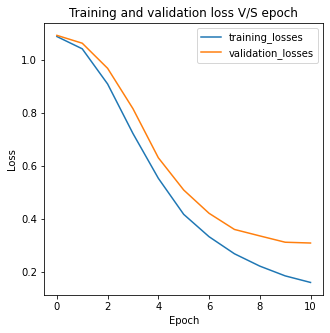

In [905]:
# function to plot the learning process
def plot_learning_process(ax, tl, vl,title):
    ax.plot(range(len(tl)), tl, label = 'training_losses')
    ax.plot(range(len(vl)), vl, label = 'validation_losses')
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    

fig, ax = plt.subplots(1,1, figsize=(5,5))
plot_learning_process(ax, loss_tr, dev_loss, title="Training and validation loss V/S epoch")

#### Does your model overfit, underfit or is about right?

As is evident from the curve seen above, the curves for both training and validation losses are approximately of the same shape so, we can say that the model does not underfit. As the curves are not totally overlapping, hence there is no overfitting as well.

### Hyperparameter tuning

In [944]:
# Hyperparameter tuning
# The hyperparameters tuned below are - regularisation strength(dropout_rate) and learning_rate(lr)
np.random.seed(123)  #fixing the seed for regeneration

def hyperparameter_tuning(train_set, train_labels, W, val_set, val_labels, epochs):
    dropout_opts = [0.1, 0.4, 0.8]
    lr_opts = np.logspace(start = -4, stop = -1, num = 5)

    min_loss = 9999999

    best_dropout = 0
    best_lr = 0
    
    for lr in lr_opts:
        fig, axes = plt.subplots(1,3, figsize = (30,15))
        for ax,d in zip(axes.flatten(),dropout_opts):
            w, tl, vl = SGD(train_set, train_labels, W, val_set, val_labels, 
                                lr = lr, 
                                dropout=d,
                                freeze_emb=False,
                                tolerance=0.01,
                                epochs=epochs,
                                print_progress = False)
            
            loss_tr = np.mean(tl)
            loss_val = np.mean(vl)
            
            #plot learning progress for each hyperparameter combination
            plot_learning_process(ax, tl, vl, title="lr= "+str(lr)+" dropout= "+str(d))

            if loss_val < min_loss: 
                min_loss = loss_val
                best_dropout = d
                best_lr = lr 
            
    print("Best params- ")
    print("Dropout Rate: "+ str(best_dropout)+ " Learning Rate" + str(best_lr))
    
    return best_lr, best_dropout

Compute accuracy, precision, recall and F1-Score:

In [915]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['p']) 
            for x,y in zip(test_idx,test_true_labels)]

print('Accuracy:', accuracy_score(test_true_labels,preds_te))
print('Precision:', precision_score(test_true_labels,preds_te,average='macro'))
print('Recall:', recall_score(test_true_labels,preds_te,average='macro'))
print('F1-Score:', f1_score(test_true_labels,preds_te,average='macro'))

Accuracy: 0.8655555555555555
Precision: 0.8670756235367006
Recall: 0.8655555555555555
F1-Score: 0.8648255926745043


### Discuss how did you choose model hyperparameters ? 

Best params- 
Dropout Rate: 0.8 Learning Rate0.1


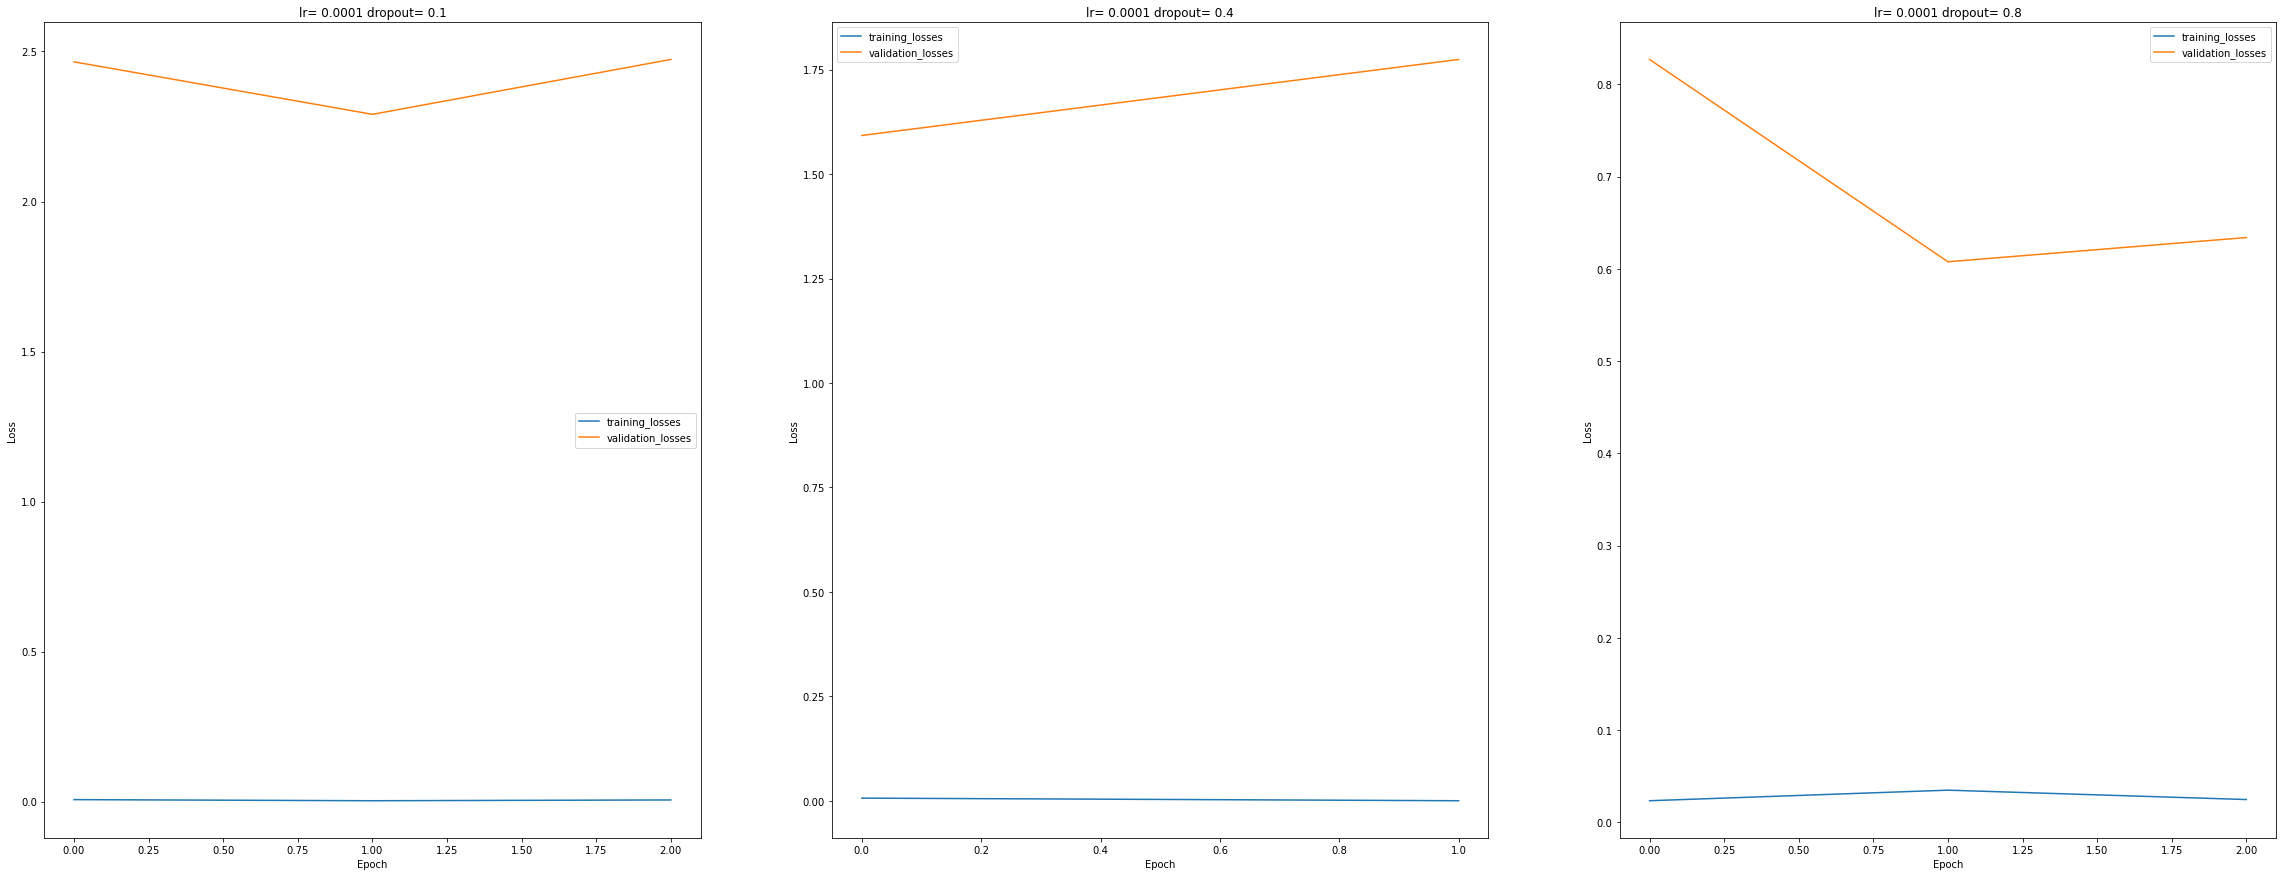

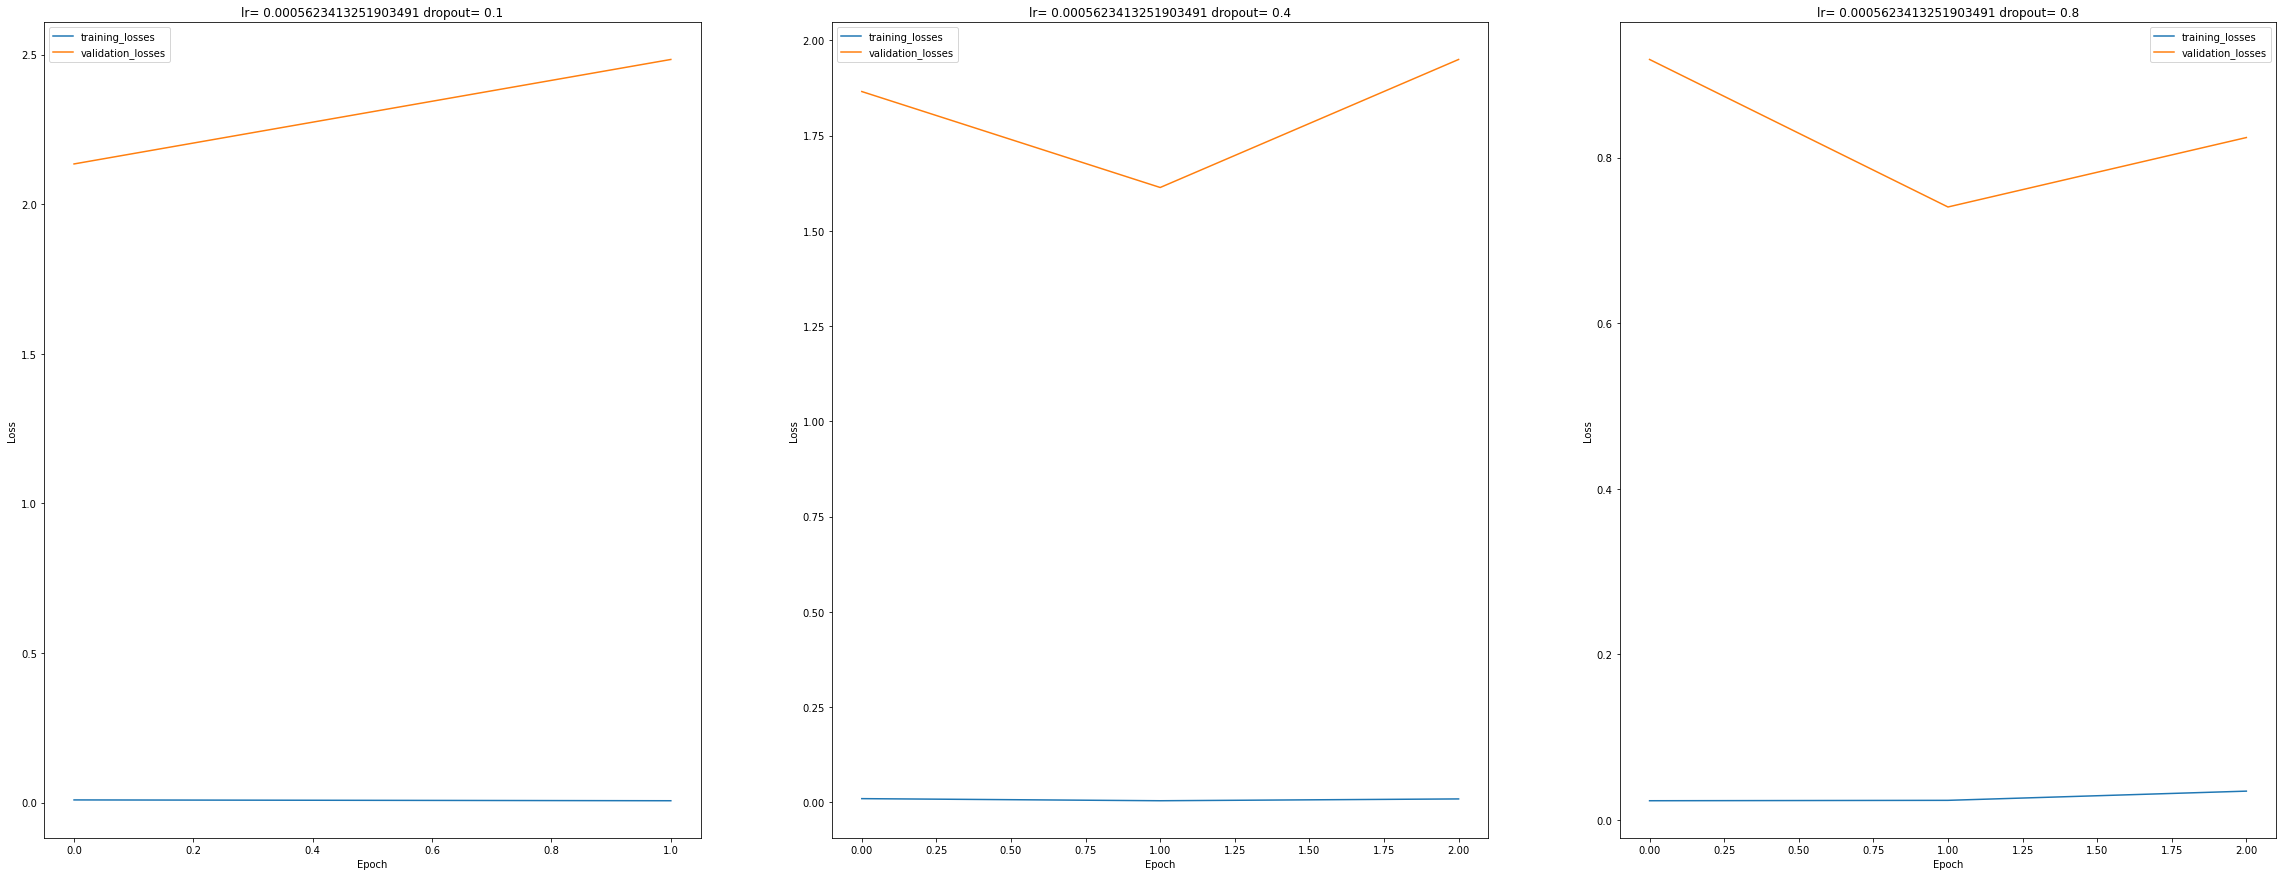

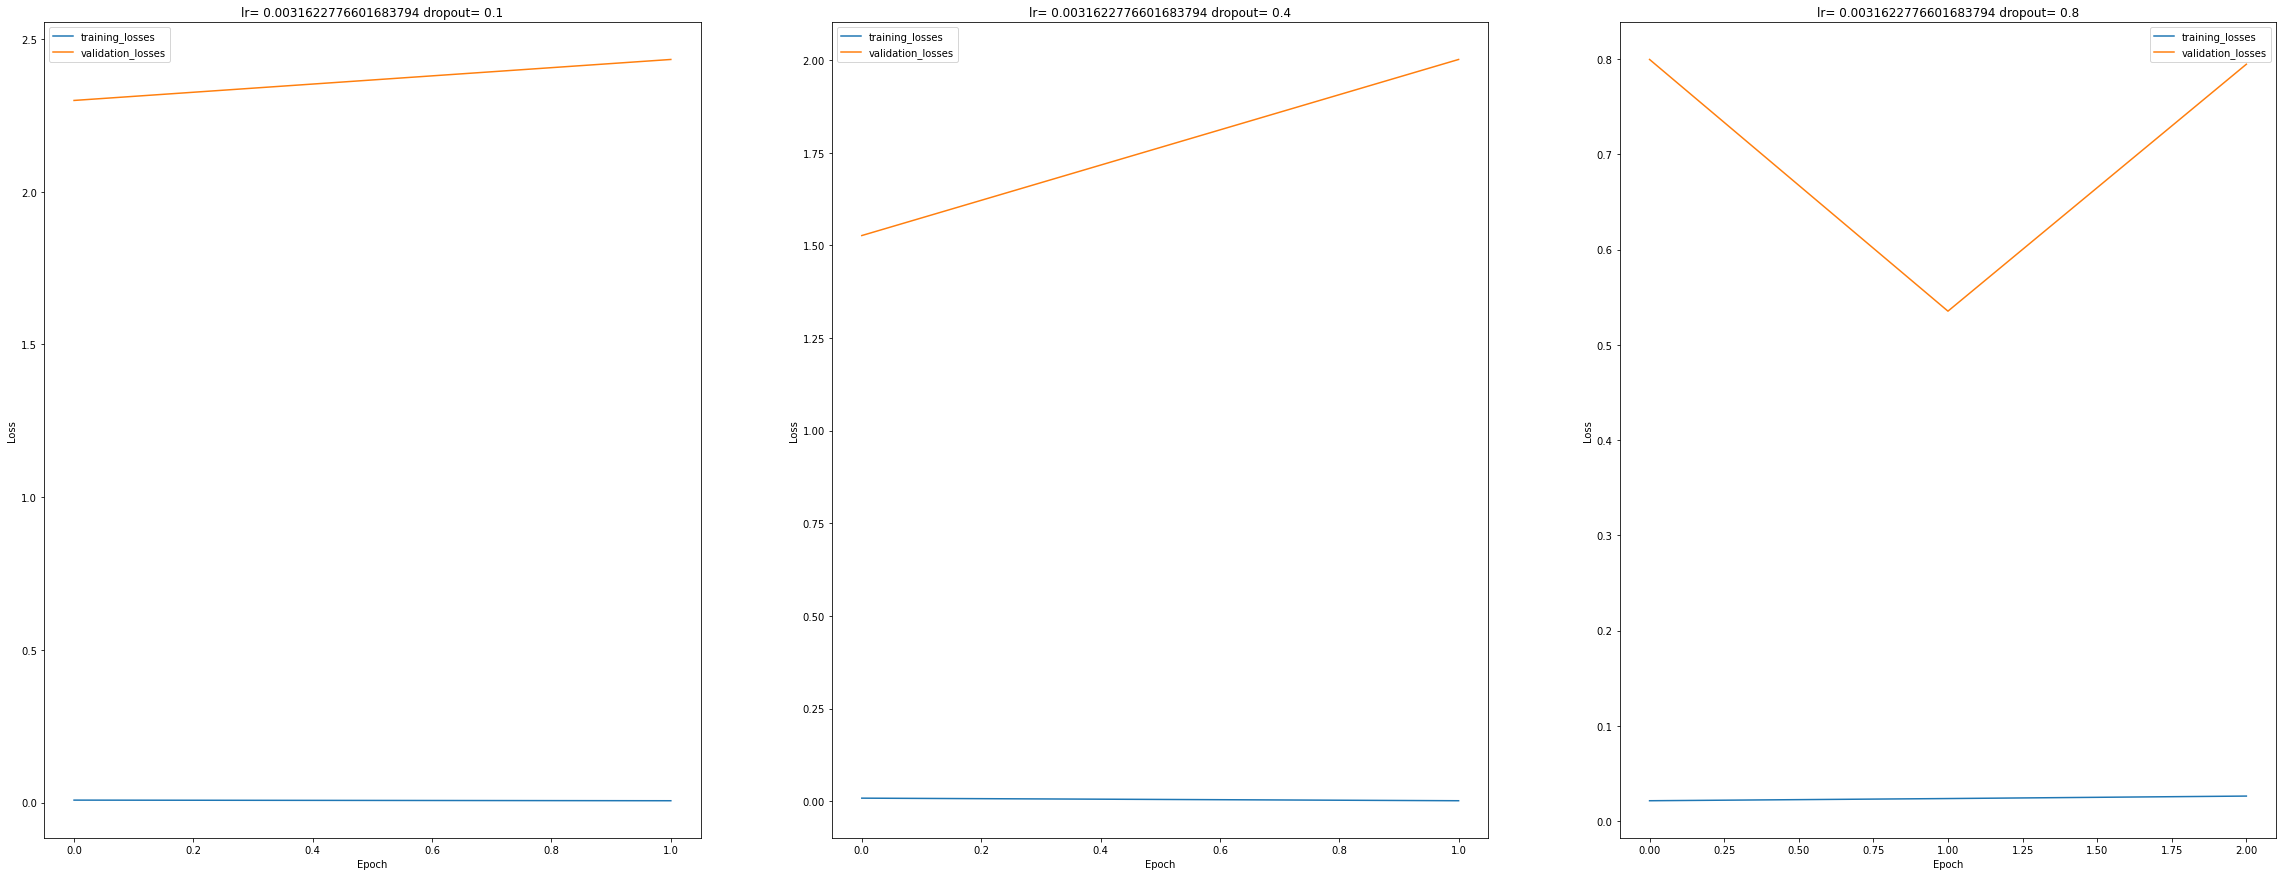

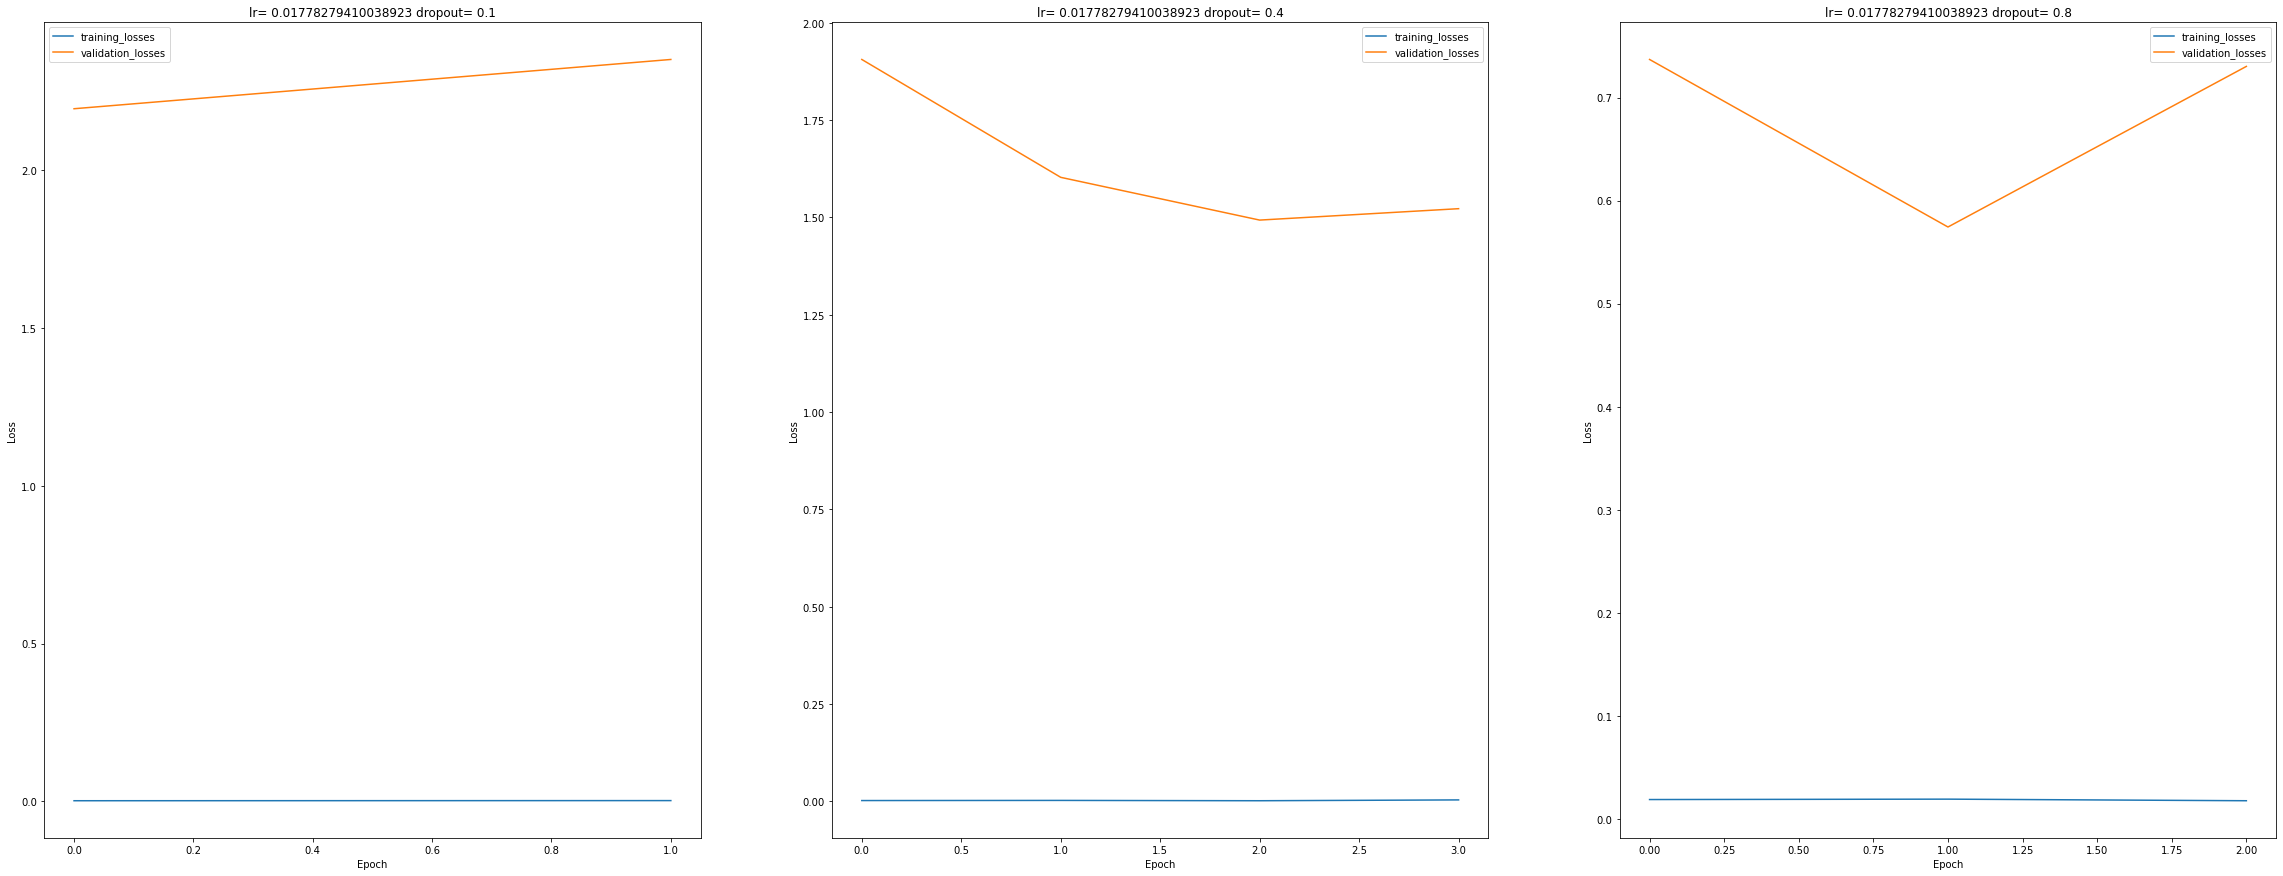

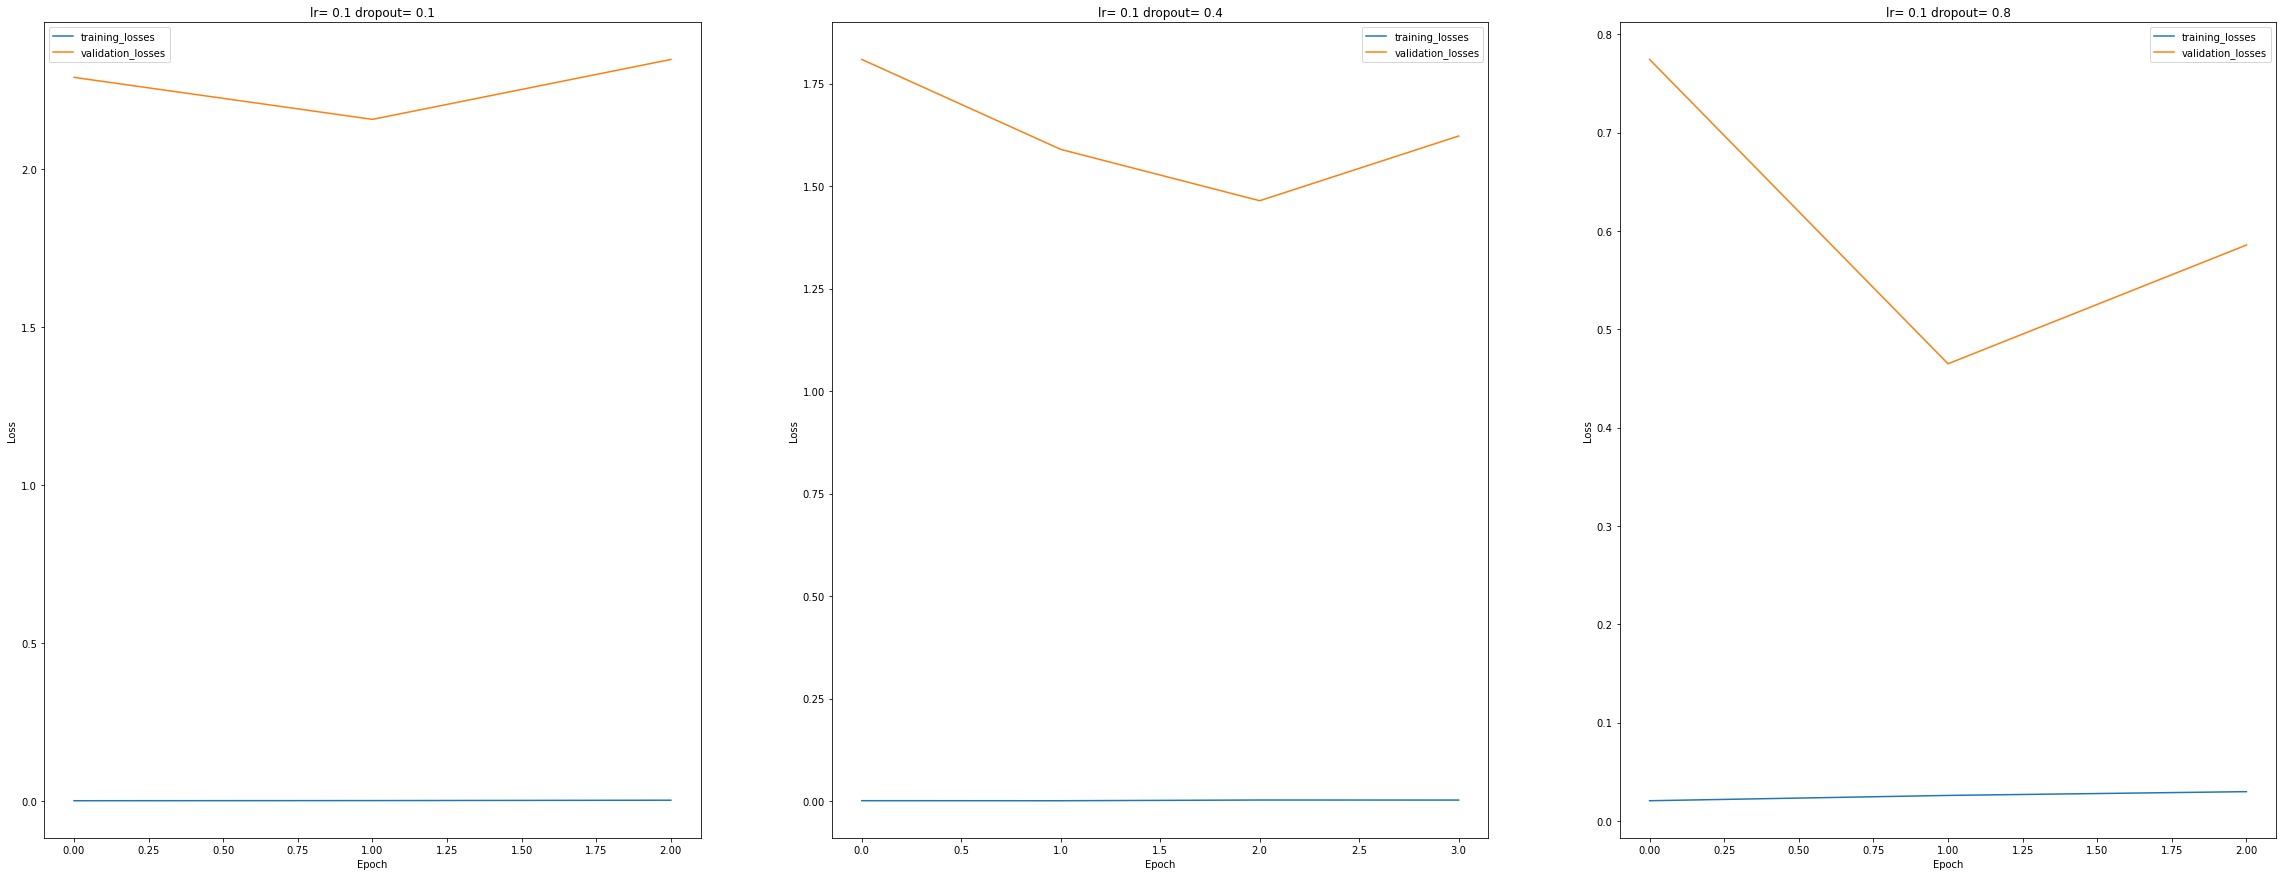

In [928]:
#Calling the hyperparameter_tuning function to tune hyperparameters
best_lr, best_dropout = hyperparameter_tuning(train_idx, train_labels, W, val_idx, val_labels, 20)

For selecting the best set of hyperparameters, the grid search algorithm is used. 15 different combinations of the learning rate and the dropout rate were compared which are the two main hyperparameters in the model. We selected the best parameters based on the losses for each combination. The combination with minimum losses were selected as the best parameters.

In [925]:
W, loss_tr, dev_loss = SGD(train_idx, train_labels,
                            W,
                            X_dev=val_idx, 
                            Y_dev=val_labels,
                            lr=best_lr, 
                            dropout=best_dropout,
                            freeze_emb=False,
                            tolerance=0.01,
                            epochs=50)

Epoch =  0
Training_loss : 0.026492145875141173
Validation_loss : 0.8729548249022135


In [926]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['p']) 
            for x,y in zip(test_idx,test_true_labels)]

print('Accuracy:', accuracy_score(test_true_labels,preds_te))
print('Precision:', precision_score(test_true_labels,preds_te,average='macro'))
print('Recall:', recall_score(test_true_labels,preds_te,average='macro'))
print('F1-Score:', f1_score(test_true_labels,preds_te,average='macro'))

Accuracy: 0.87
Precision: 0.8697209069160289
Recall: 0.87
F1-Score: 0.8691164497599152


# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [842]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [1215]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",vocab_word2id)
len(w_glove)

8875

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [1016]:
W = network_weights(vocab_size=len(w_glove),embedding_dim=300,hidden_dim=[], num_classes=3) 
W[0] = w_glove #Setting the weights of the embedding layer 

W, loss_tr, dev_loss = SGD(train_idx, train_labels, W,
                           X_dev=val_idx, Y_dev=val_labels, 
                           lr=0.01, 
                           dropout=0.1, 
                           freeze_emb=True, 
                           tolerance=0.001, 
                           epochs=50)

Epoch =  0
Training_loss : 1.0558817250097632
Validation_loss : 1.0594258895045268


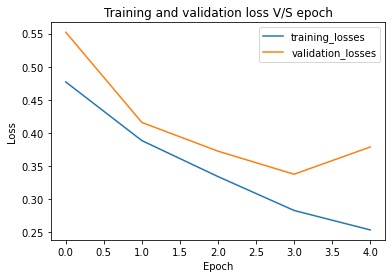

In [1008]:
fig, ax = plt.subplots(1,1)
plot_learning_process(ax, loss_tr, dev_loss, title="Training and validation loss V/S epoch")

In [1017]:
np.random.seed(123)
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['p']) 
            for x,y in zip(test_idx,test_true_labels)]

print('Accuracy:', accuracy_score(test_true_labels,preds_te))
print('Precision:', precision_score(test_true_labels,preds_te,average='macro'))
print('Recall:', recall_score(test_true_labels,preds_te,average='macro'))
print('F1-Score:', f1_score(test_true_labels,preds_te,average='macro'))

Accuracy: 0.6455555555555555
Precision: 0.6587220113575435
Recall: 0.6455555555555555
F1-Score: 0.6483202438656376


### Discuss how did you choose model hyperparameters ? 

In [1018]:
# Hyperparameter tuning
# The hyperparameters tuned below are - regularisation strength(dropout_rate) and learning_rate(lr)
np.random.seed(123)  #fixing the seed for regeneration

def hyperparameter_tuning(train_set, train_labels, W, val_set, val_labels, epochs):
    dropout_opts = [0.1, 0.4, 0.8]
    lr_opts = np.logspace(start = -4, stop = -1, num = 5)

    min_loss = 9999999

    best_dropout = 0
    best_lr = 0
    
    for lr in lr_opts:
        fig, axes = plt.subplots(1,3, figsize = (30,15))
        for ax,d in zip(axes.flatten(),dropout_opts):
            w, tl, vl = SGD(train_set, train_labels, W, val_set, val_labels, 
                                lr = lr, 
                                dropout=d,
                                freeze_emb=True,
                                tolerance=0.01,
                                epochs=epochs,
                                print_progress = False)
            
            loss_tr = np.mean(tl)
            loss_val = np.mean(vl)
            
            #plot learning progress for each hyperparameter combination
            plot_learning_process(ax, tl, vl, title="lr= "+str(lr)+" dropout= "+str(d))

            if loss_val < min_loss: 
                min_loss = loss_val
                best_dropout = d
                best_lr = lr 
            
    print("Best params- ")
    print("Dropout Rate: "+ str(best_dropout)+ " Learning Rate" + str(best_lr))
    
    return best_lr, best_dropout

Best params- 
Dropout Rate: 0.1 Learning Rate0.1


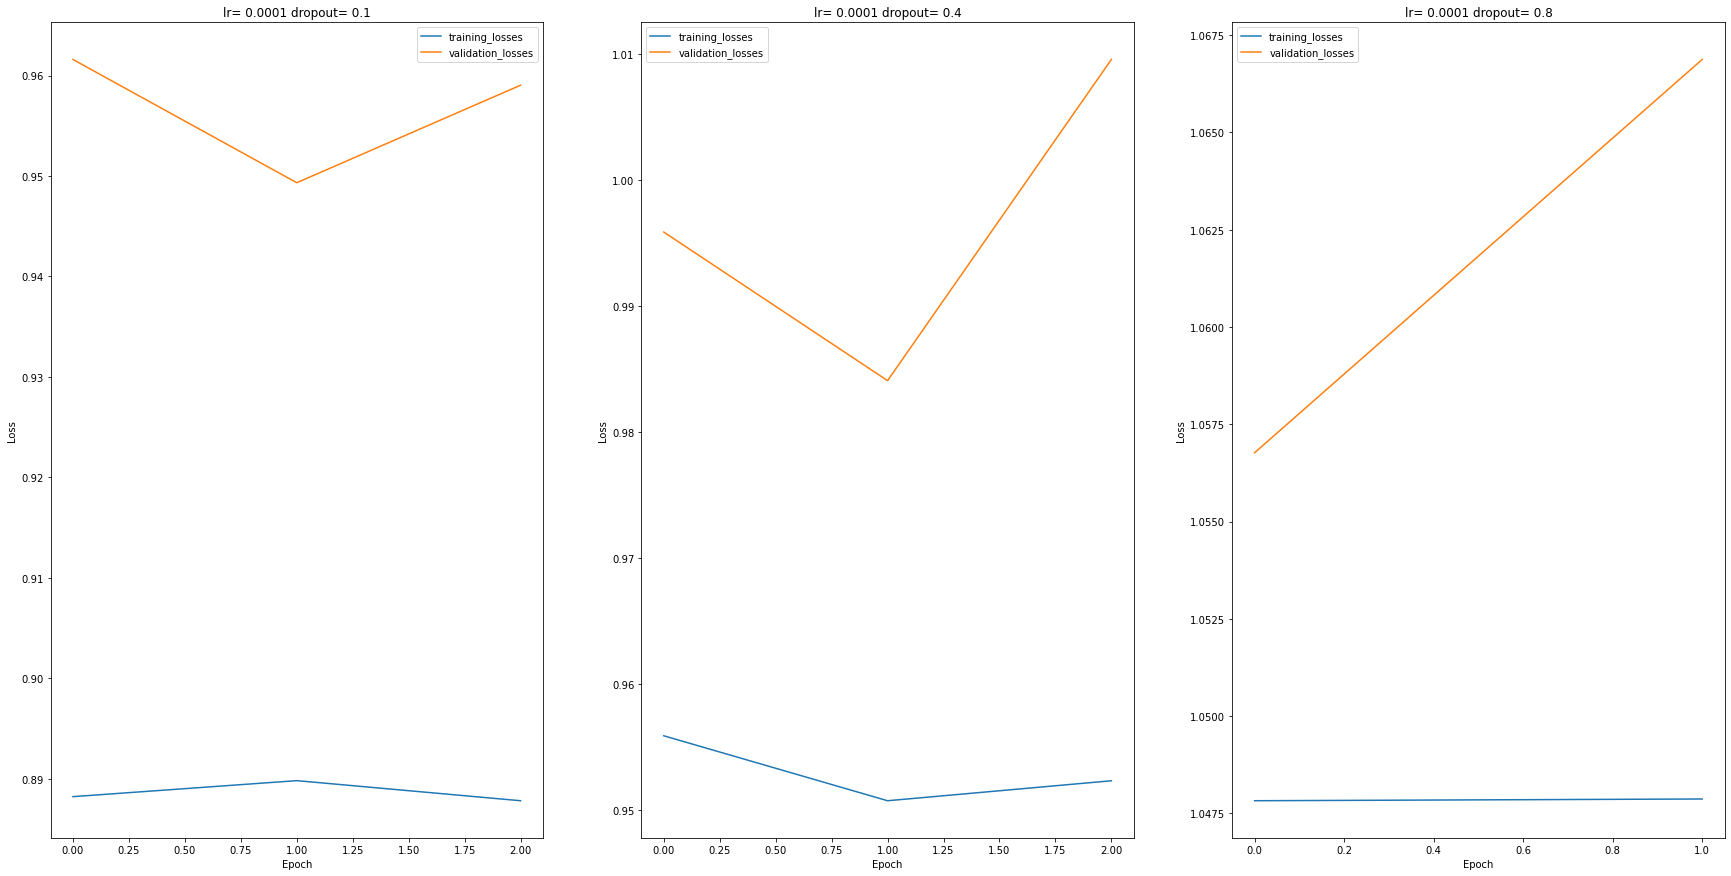

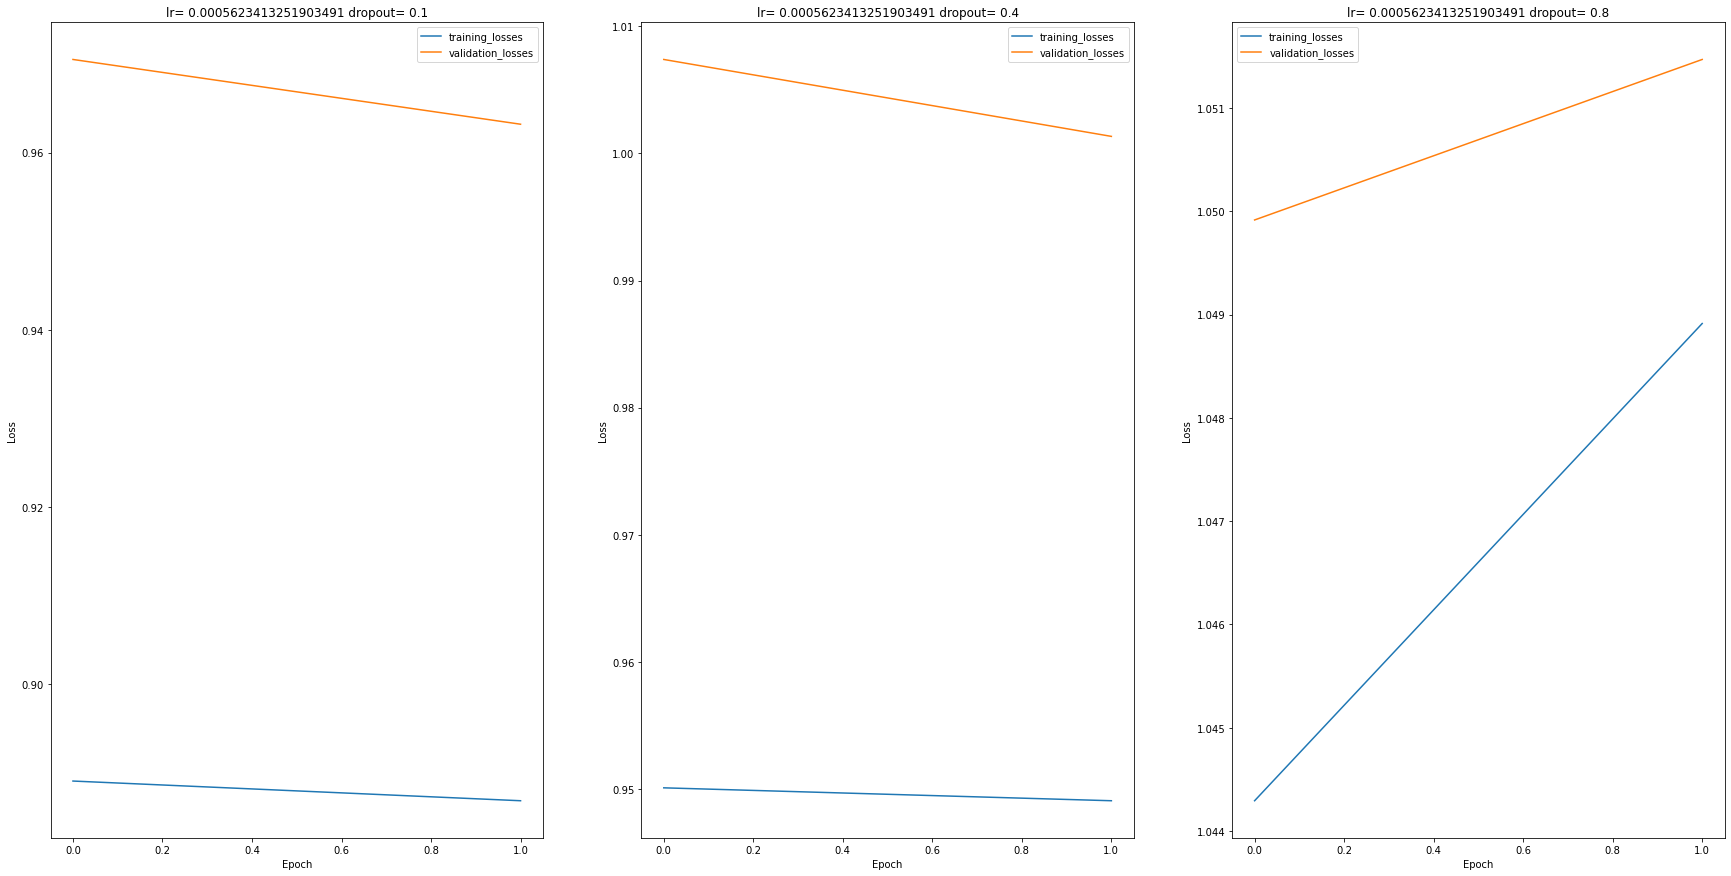

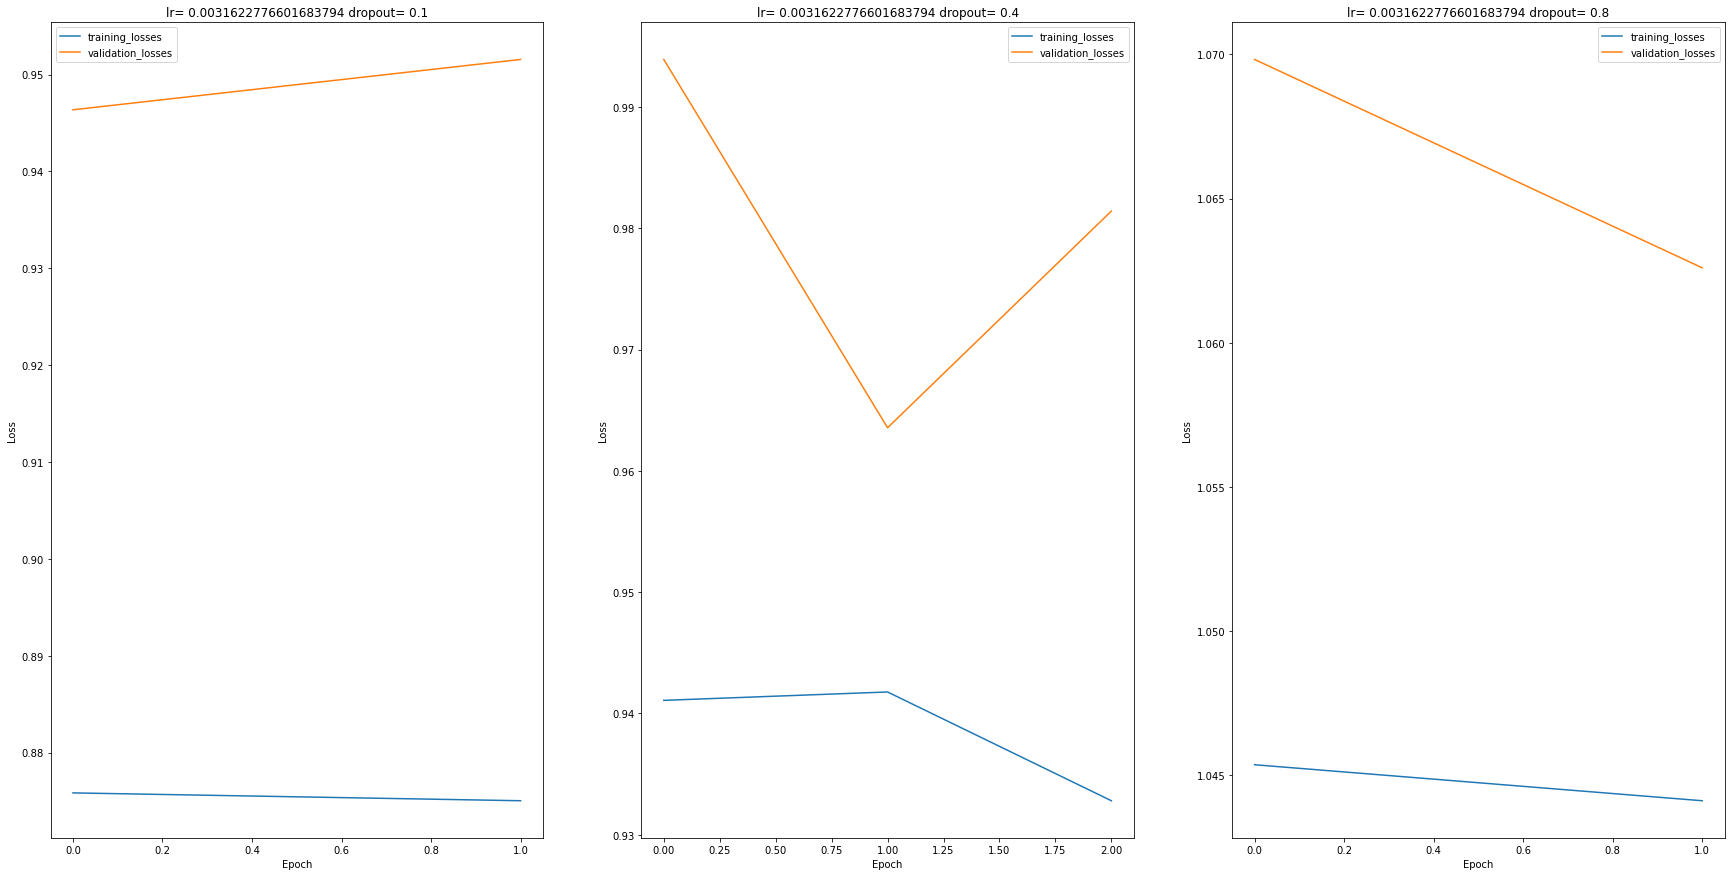

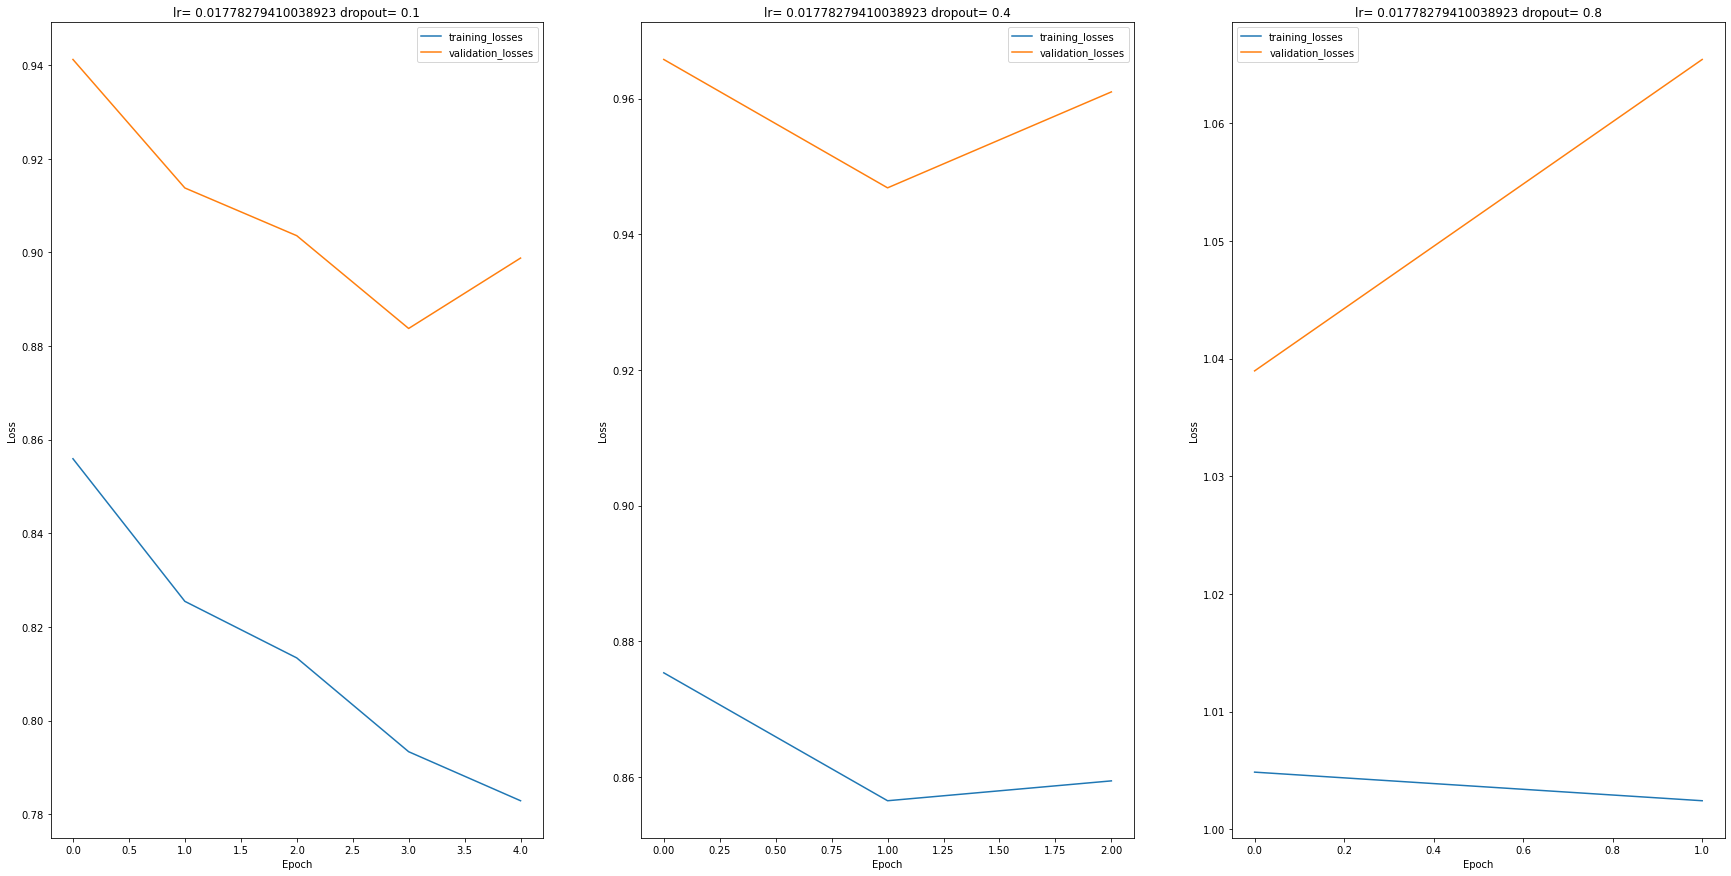

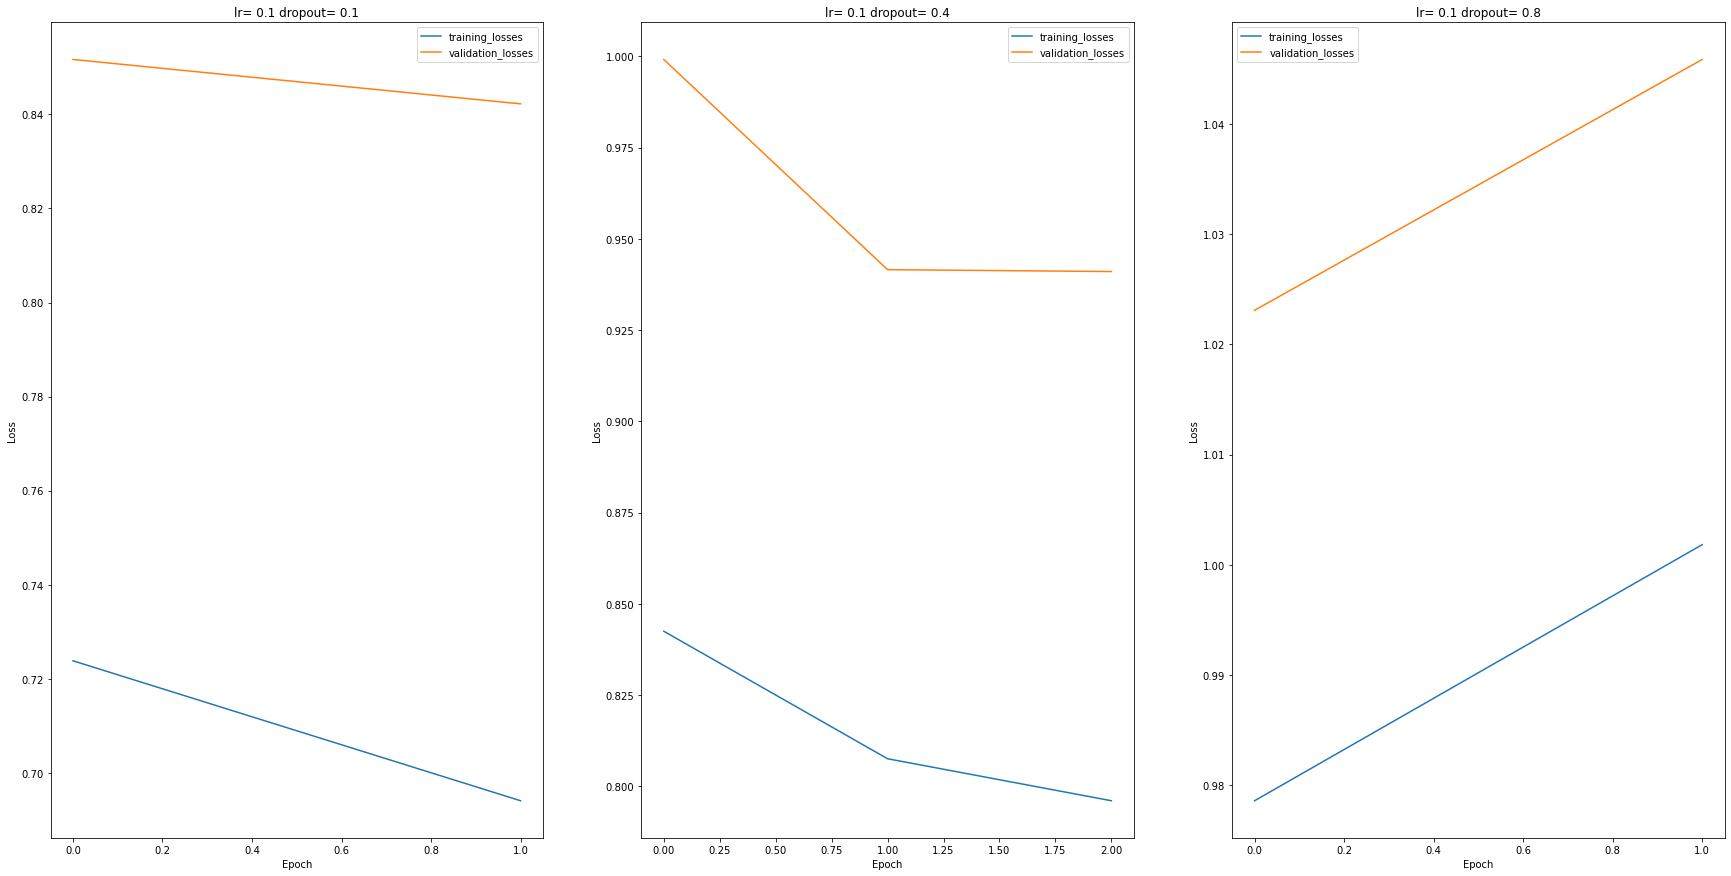

In [1019]:
#Calling the hyperparameter_tuning function to tune hyperparameters
best_lr, best_dropout = hyperparameter_tuning(train_idx, train_labels, W, val_idx, val_labels, 20)

In [1020]:
W, loss_tr, dev_loss = SGD(train_idx, train_labels,
                            W,
                            X_dev=val_idx, 
                            Y_dev=val_labels,
                            lr=best_lr, 
                            dropout=best_dropout,
                            freeze_emb=False,
                            tolerance=0.01,
                            epochs=50)

Epoch =  0
Training_loss : 0.0722326771927221
Validation_loss : 0.3267140796450202


In [1022]:
np.random.seed(123)
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['p']) 
            for x,y in zip(test_idx,test_true_labels)]

print('Accuracy:', accuracy_score(test_true_labels,preds_te))
print('Precision:', precision_score(test_true_labels,preds_te,average='macro'))
print('Recall:', recall_score(test_true_labels,preds_te,average='macro'))
print('F1-Score:', f1_score(test_true_labels,preds_te,average='macro'))

Accuracy: 0.8611111111111112
Precision: 0.862503441692332
Recall: 0.8611111111111112
F1-Score: 0.8610196633285089


# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

In [1196]:
np.random.seed(123)
W = network_weights(vocab_size=len(w_glove),embedding_dim=300,hidden_dim=[150], num_classes=3) 
W[0] = w_glove

W, loss_tr, dev_loss = SGD(train_idx, train_labels, W,
                           X_dev=val_idx, Y_dev=val_labels, 
                           lr=0.01, 
                           dropout=0.1, 
                           freeze_emb=True, 
                           tolerance=0.001, 
                           epochs=50)

Epoch =  0
Training_loss : 0.8874639498044647
Validation_loss : 0.874812335145646


In [1197]:
np.random.seed(123)
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['p']) 
            for x,y in zip(test_idx,test_true_labels)]

print('Accuracy:', accuracy_score(test_true_labels,preds_te))
print('Precision:', precision_score(test_true_labels,preds_te,average='macro'))
print('Recall:', recall_score(test_true_labels,preds_te,average='macro'))
print('F1-Score:', f1_score(test_true_labels,preds_te,average='macro'))

Accuracy: 0.3333333333333333
Precision: 0.1111111111111111
Recall: 0.3333333333333333
F1-Score: 0.16666666666666666


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Discuss how did you choose model hyperparameters ? 

In [1158]:
# Hyperparameter tuning
# The hyperparameters tuned below are - regularisation strength(dropout_rate), learning_rate(lr) and also the hidden dimension
np.random.seed(123)  #fixing the seed for regeneration

def hyperparameter_tuning(train_set, train_labels, w_glove, val_set, val_labels, epochs):
    dropout_opts = [0.2, 0.4, 0.8]
    lr_opts = np.logspace(start = -5, stop = -1, num = 5)
    hdim_opts = [200, 150, 100, 50]
#     lr_opts = [0.01, 0.001, 0.0001]

    min_loss = 9999999

    best_dropout = 0
    best_lr = 0
    best_dim = 0
    
    for dim in hdim_opts:
        w = network_weights(vocab_size=len(w_glove),embedding_dim=300,hidden_dim=[dim], num_classes=3) 
        w[0] = w_glove
        for lr in lr_opts:
            fig, axes = plt.subplots(1,3, figsize = (20,15))
            for ax,d in zip(axes.flatten(),dropout_opts):
                w, tl, vl = SGD(train_set, train_labels, w, val_set, val_labels, 
                                lr = lr, 
                                dropout=d,
                                freeze_emb=True,
                                tolerance=0.001,
                                epochs=epochs,
                                print_progress = False)
            
                loss_tr = np.mean(tl)
                loss_val = np.mean(vl)
            
                #plot learning progress for each hyperparameter combination
                plot_learning_process(ax, tl, vl, title="lr= "+str(lr)+" dropout= "+str(d)+" Hidden_dimension: "+str(dim))

                if loss_val < min_loss: 
                    min_loss = loss_val
                    best_dropout = d
                    best_lr = lr 
                    best_dim = dim
            
    print("Best params- ")
    print("Dropout Rate: "+ str(best_dropout)+ " Learning Rate" + str(best_lr) + " Hidden_dimension: "+str(dim))
    
    return best_lr, best_dropout, best_dim

Best params- 
Dropout Rate: 0.2 Learning Rate0.01 Hidden_dimension: 50


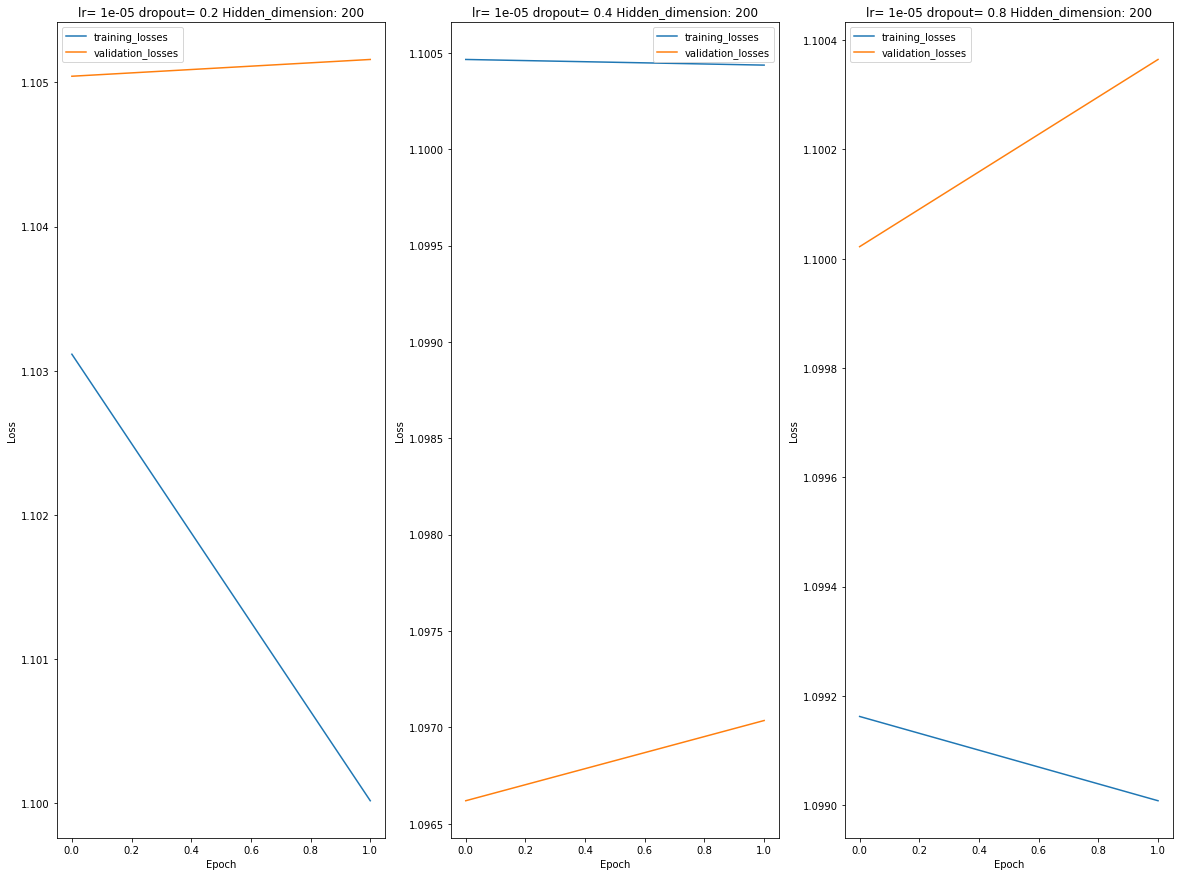

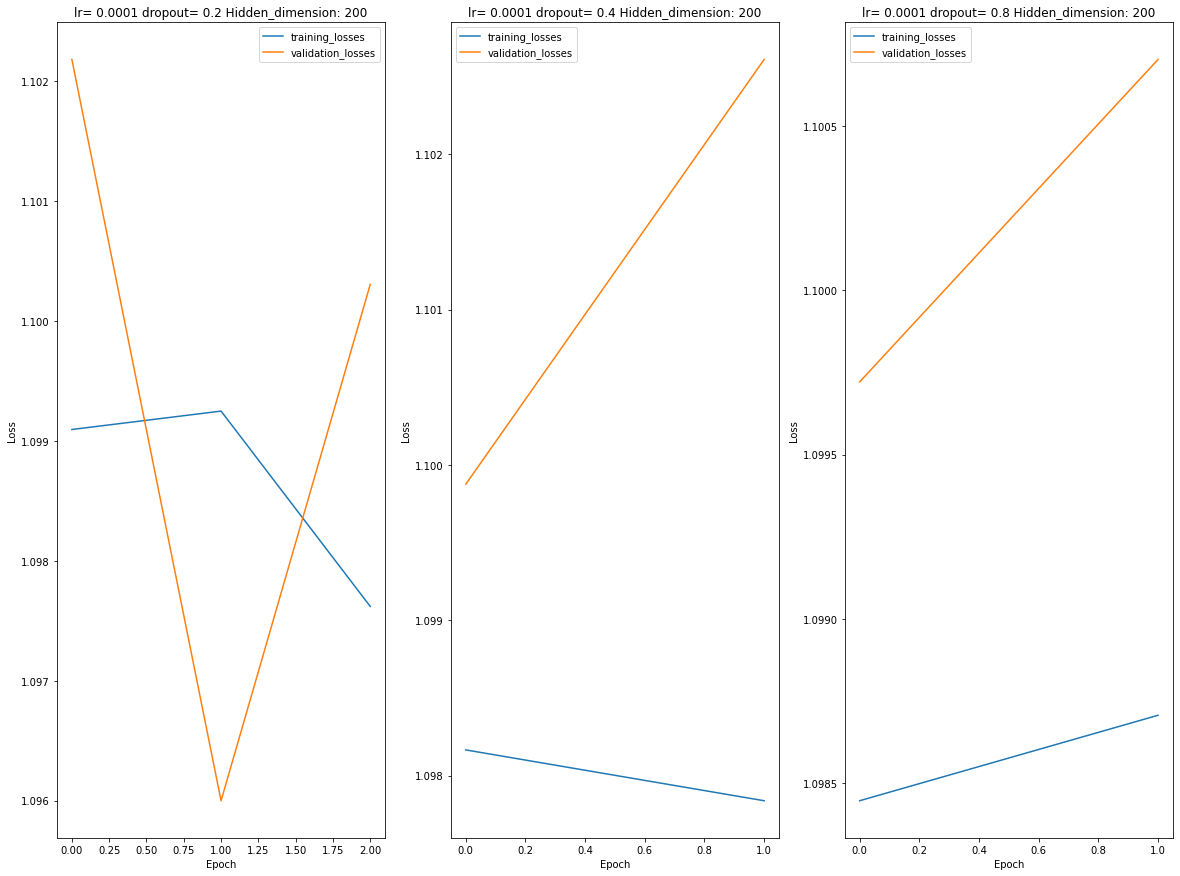

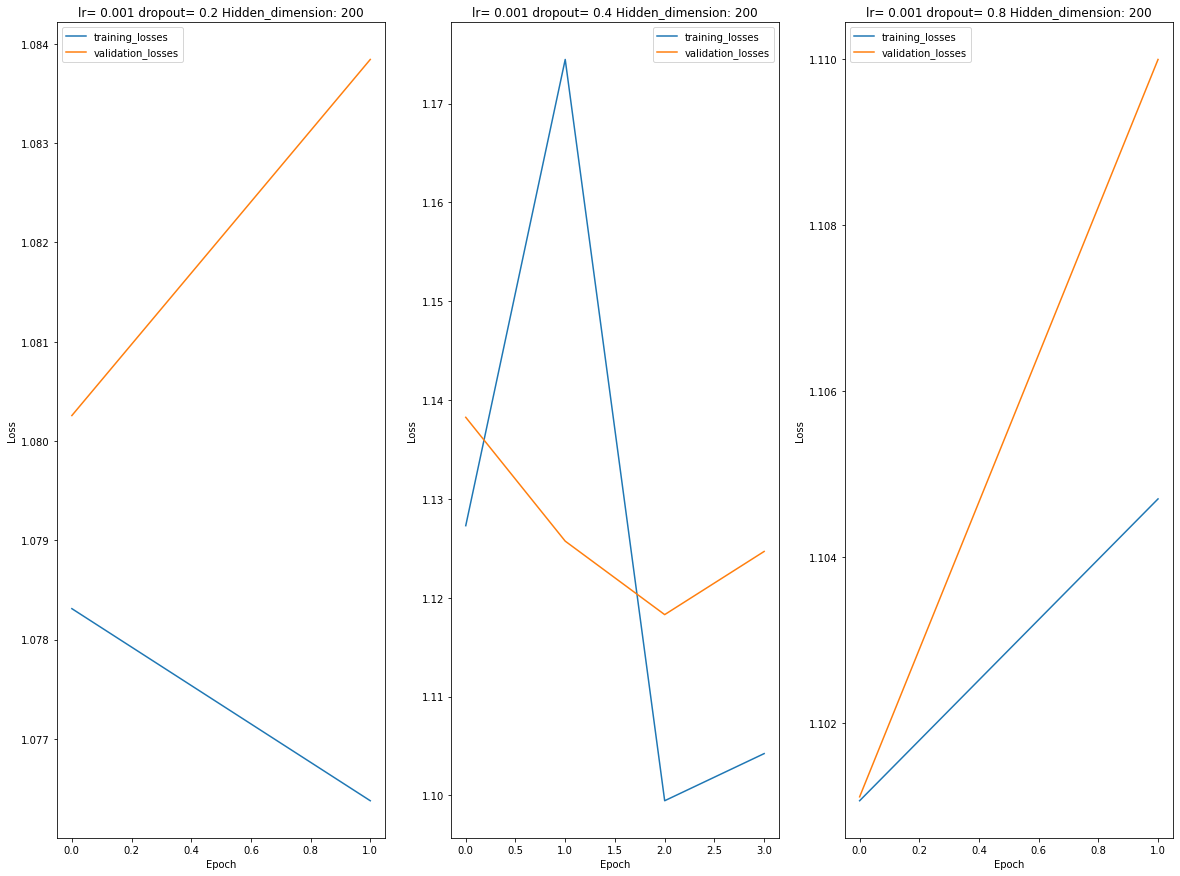

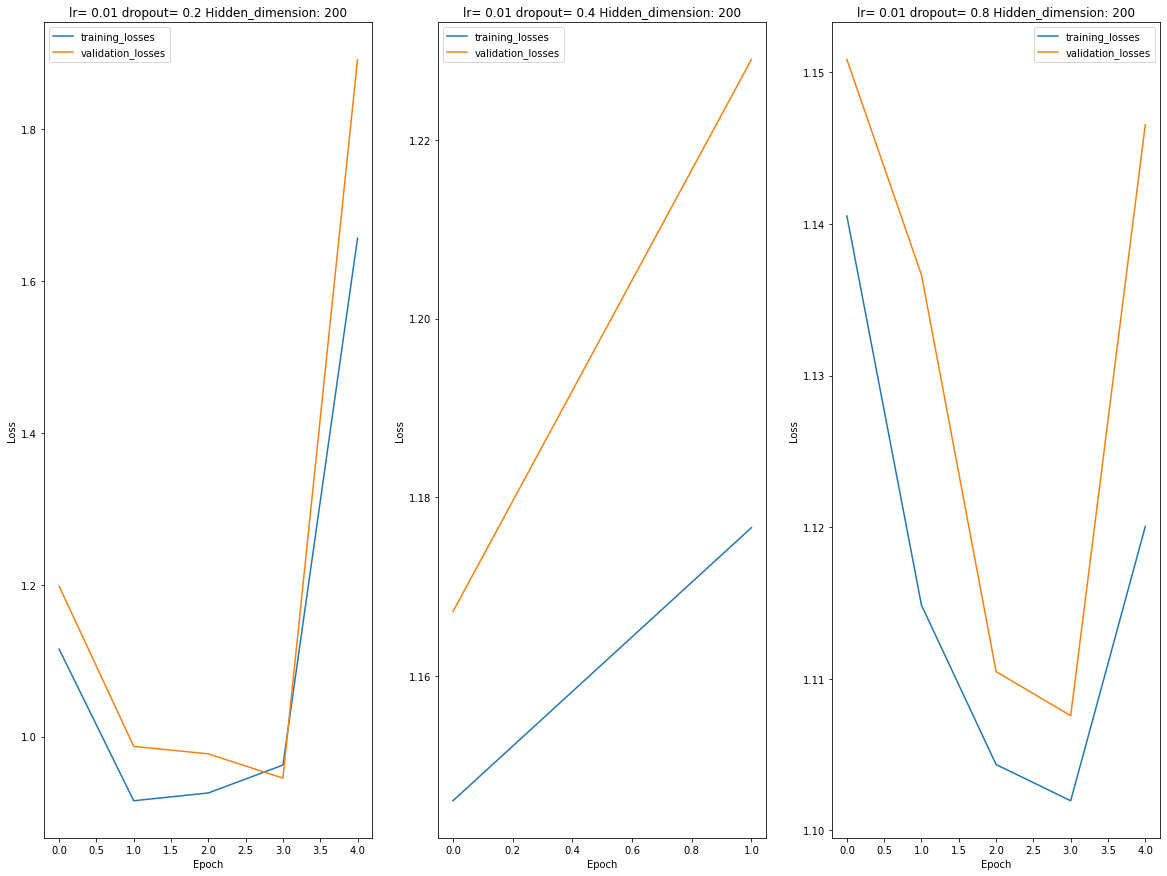

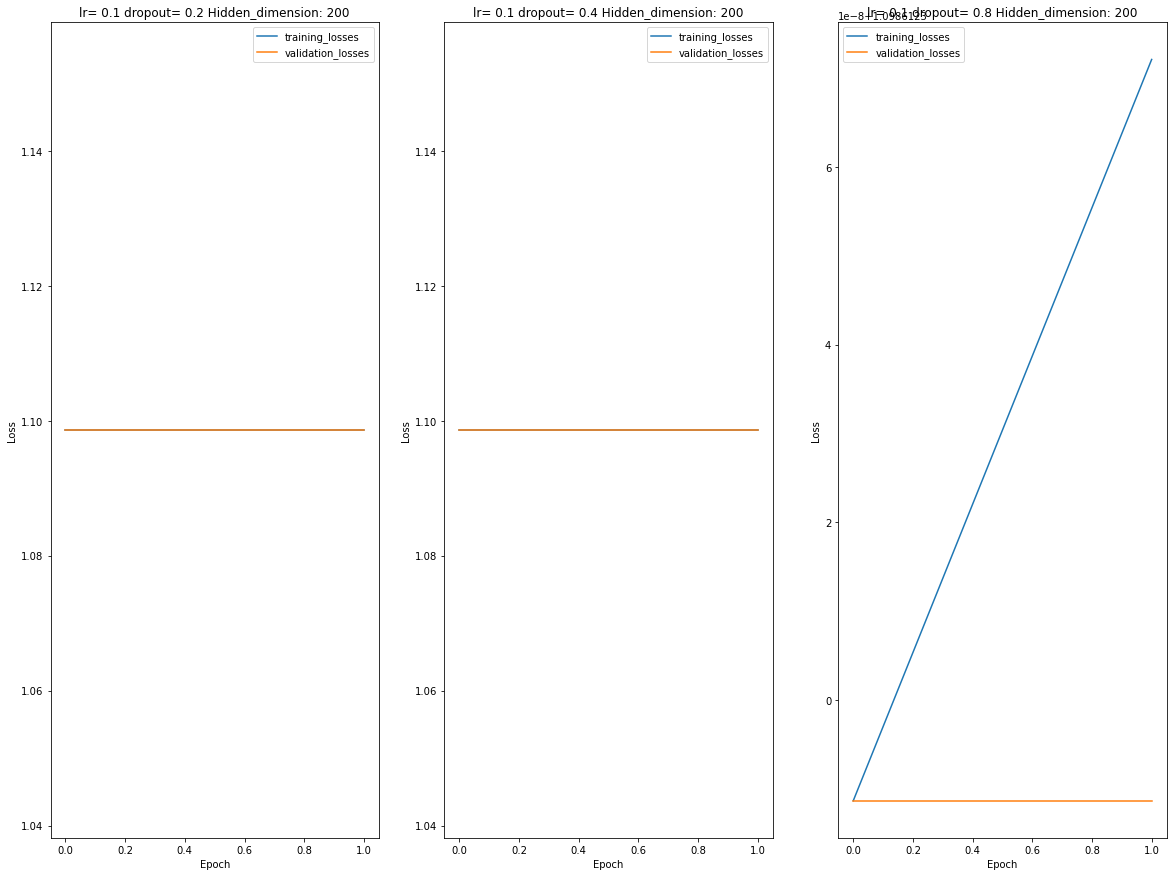

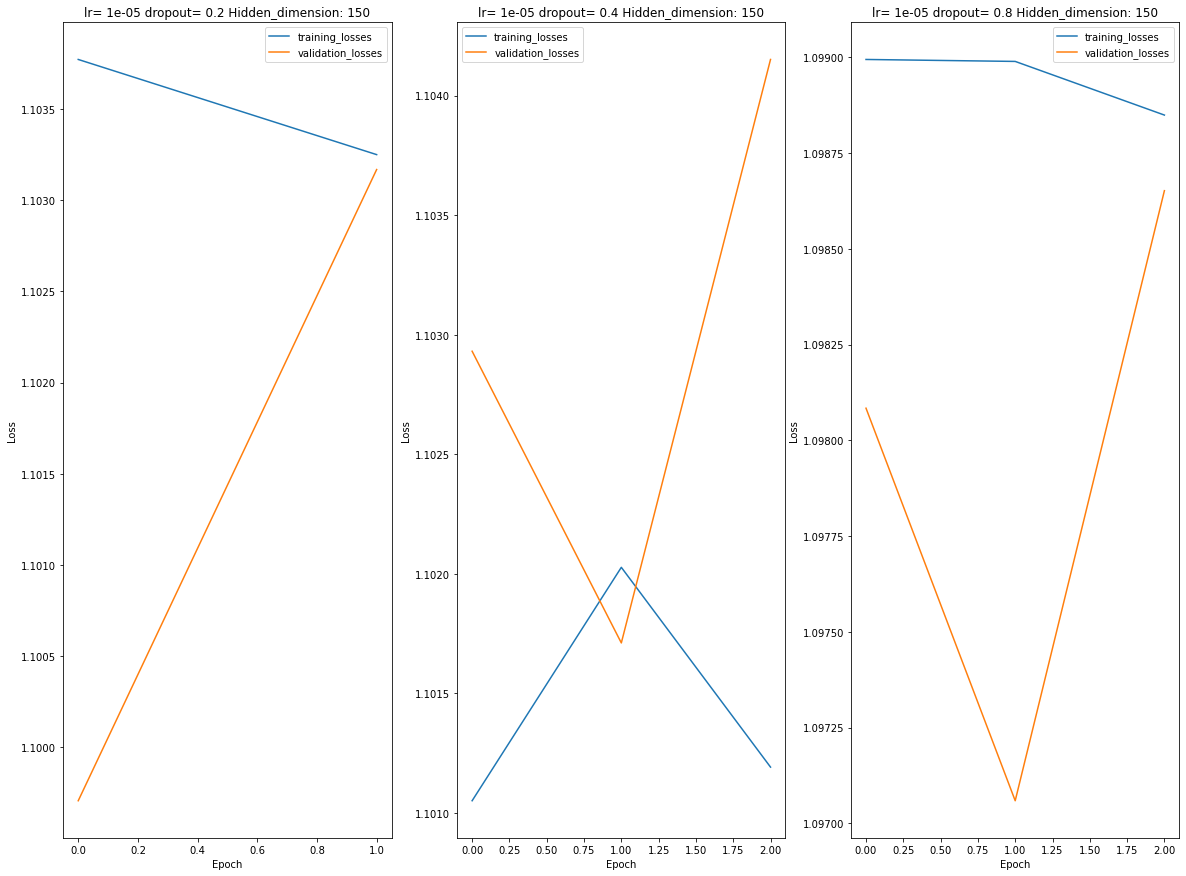

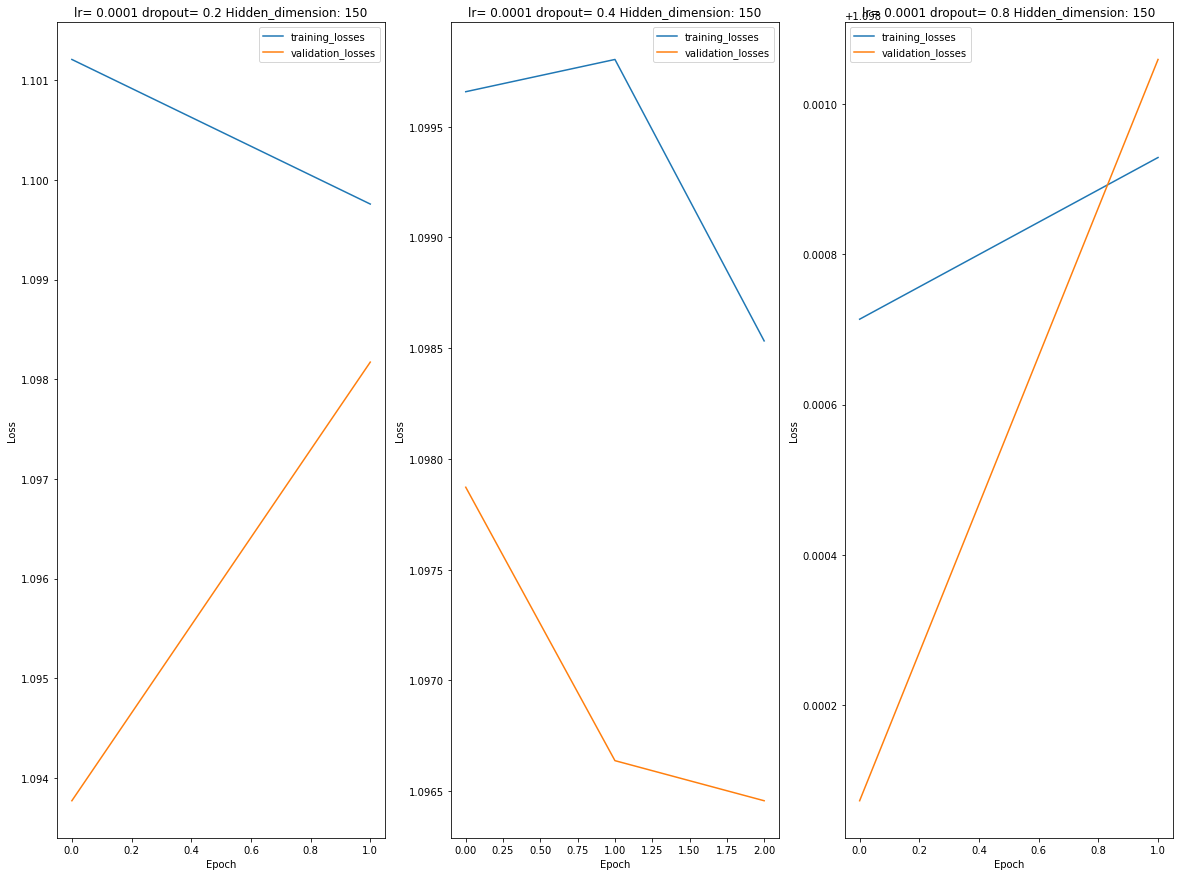

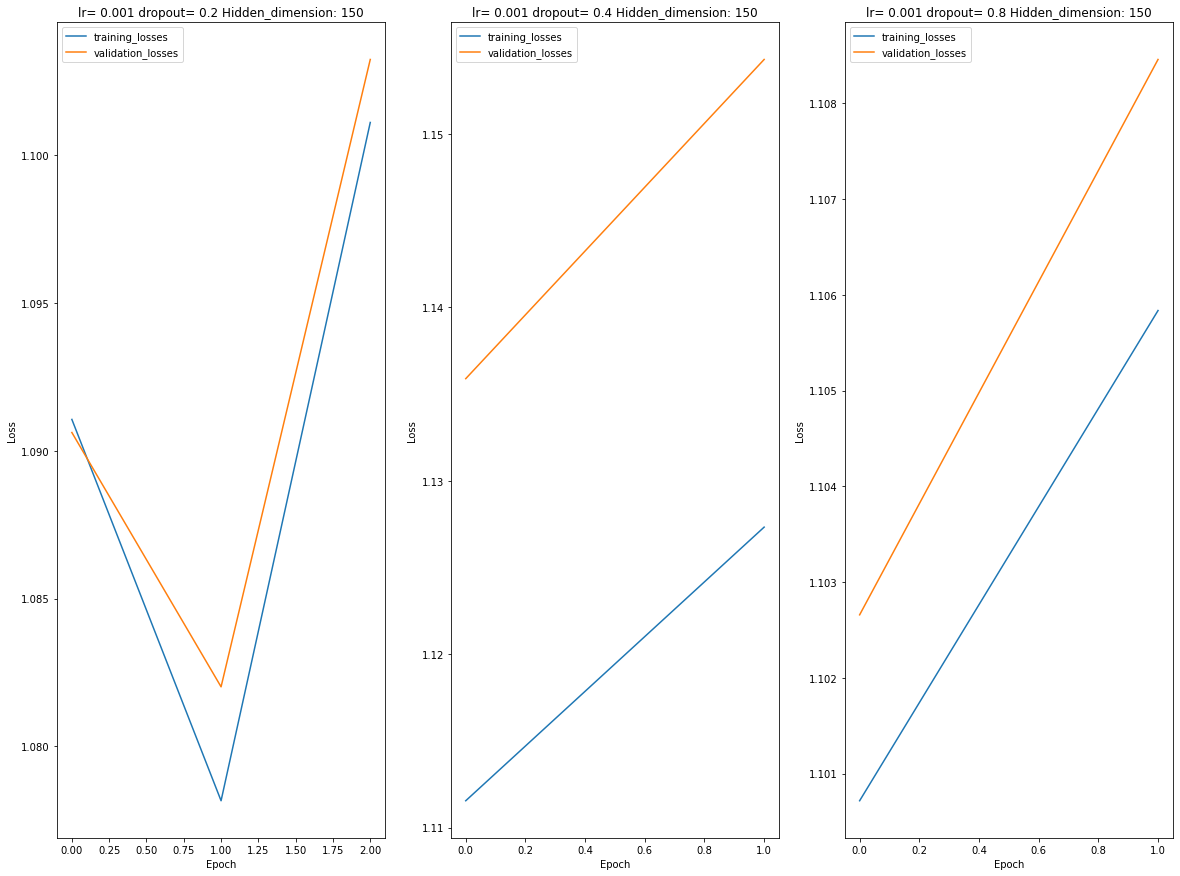

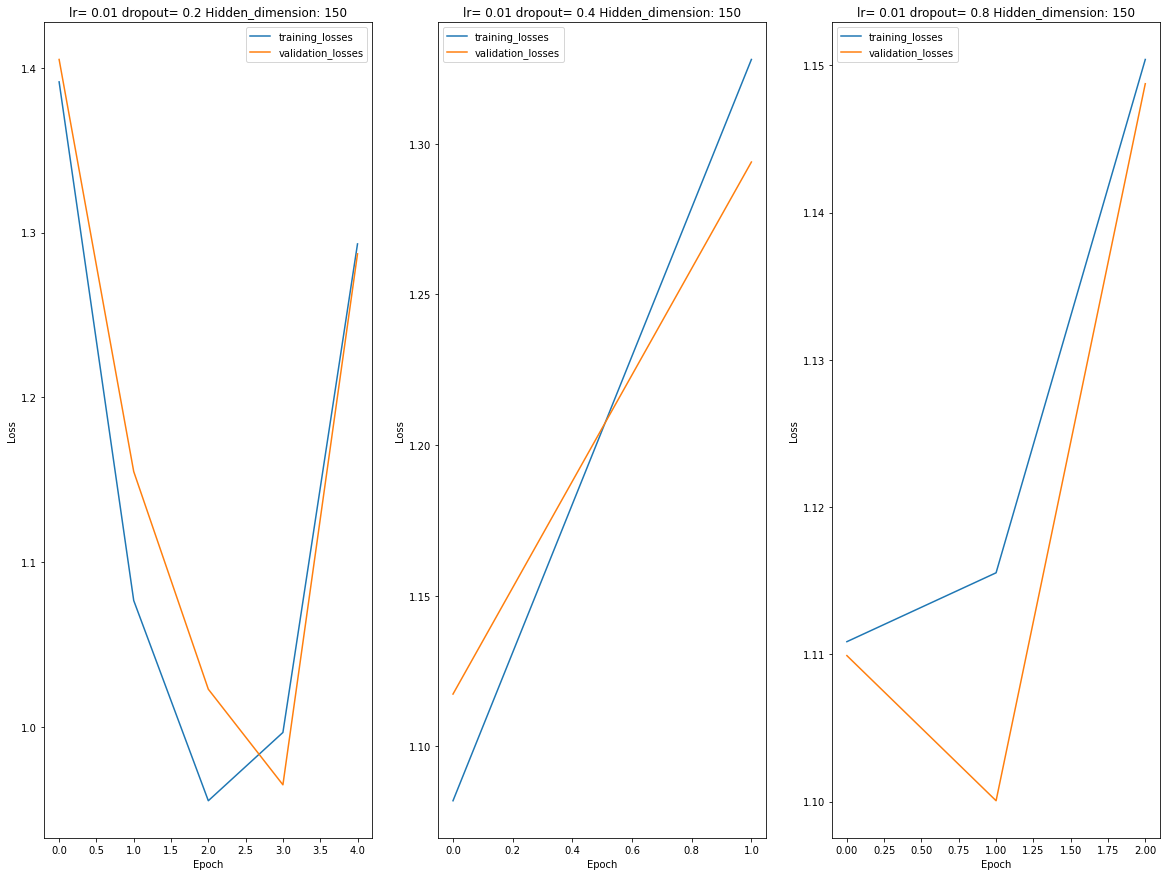

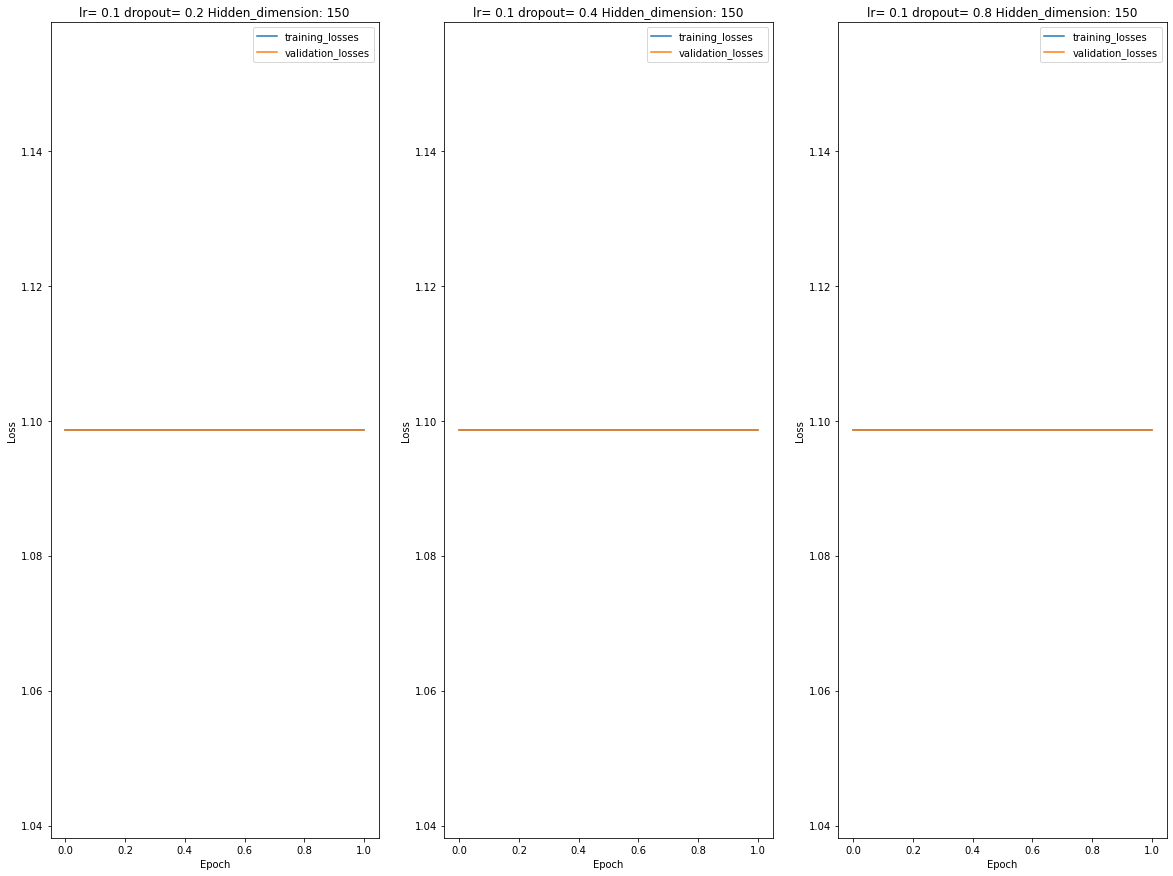

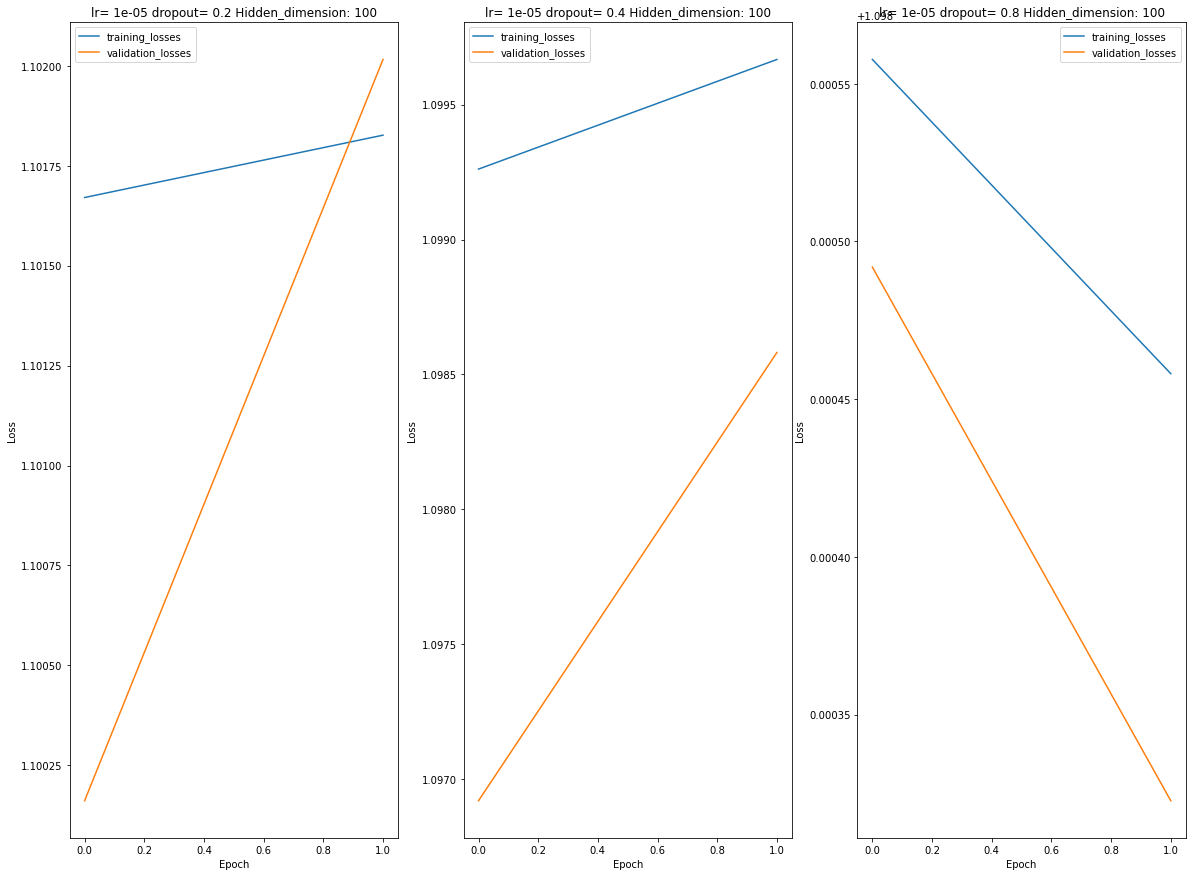

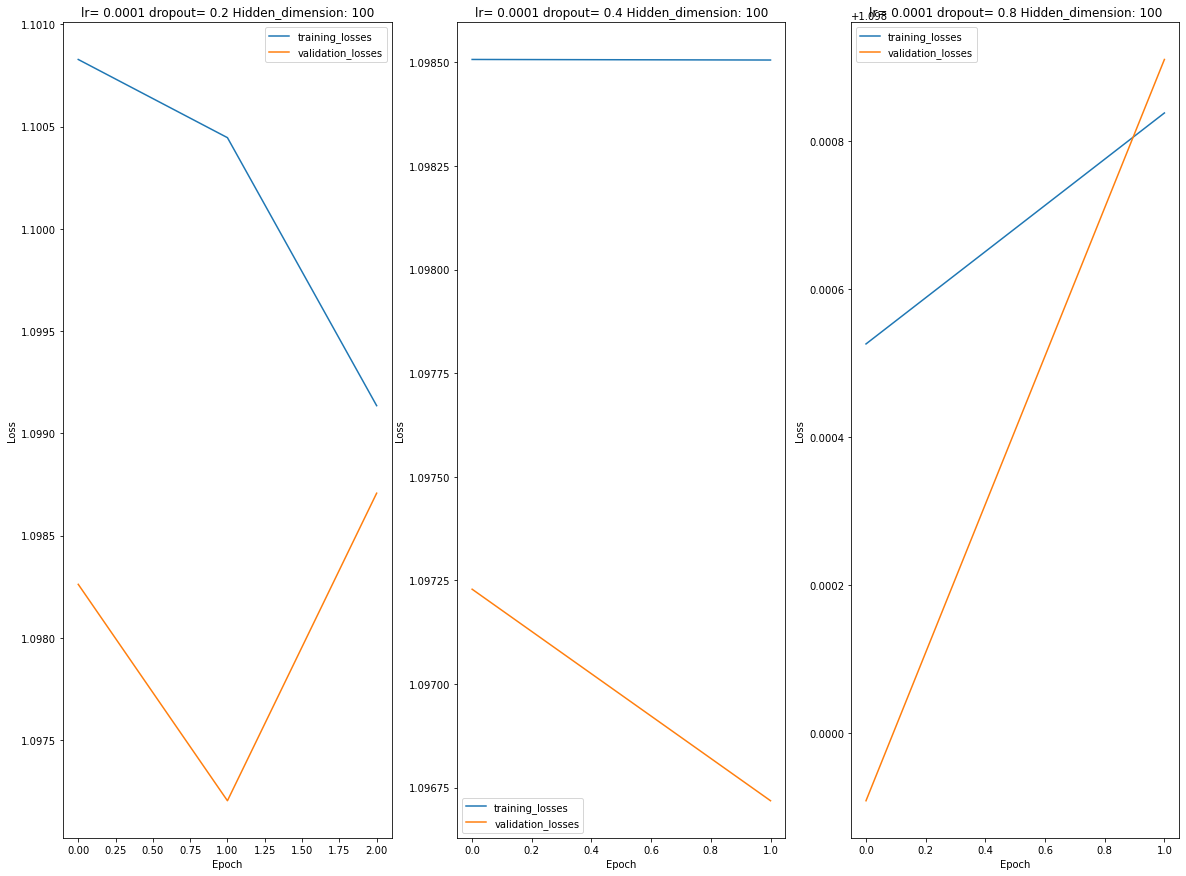

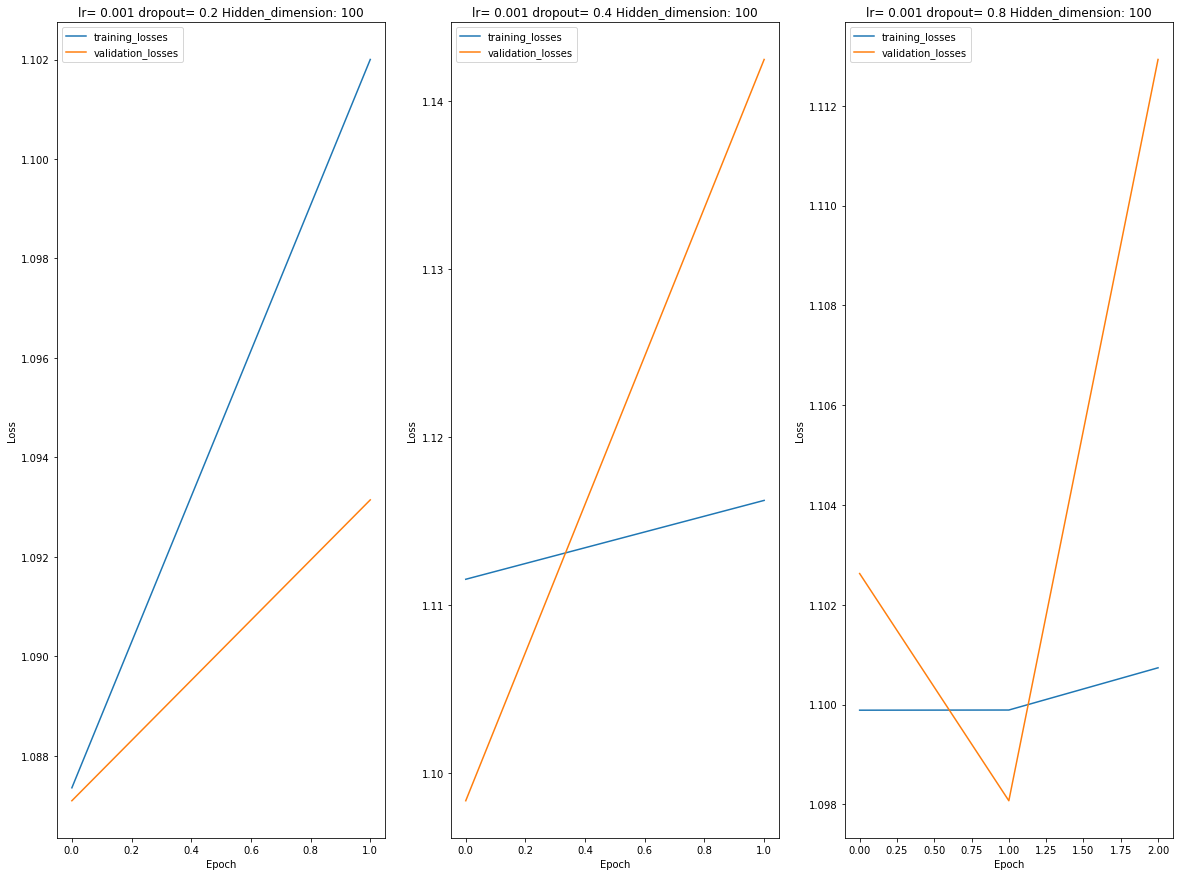

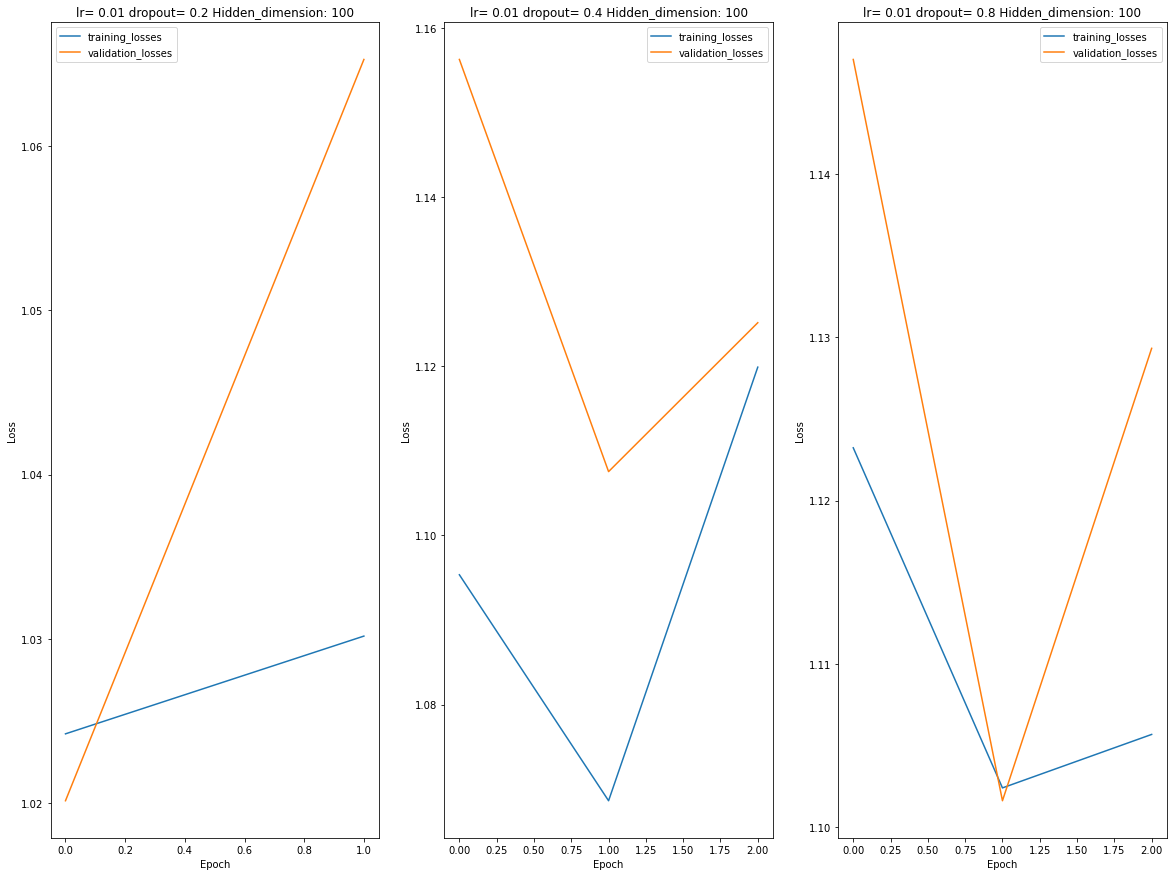

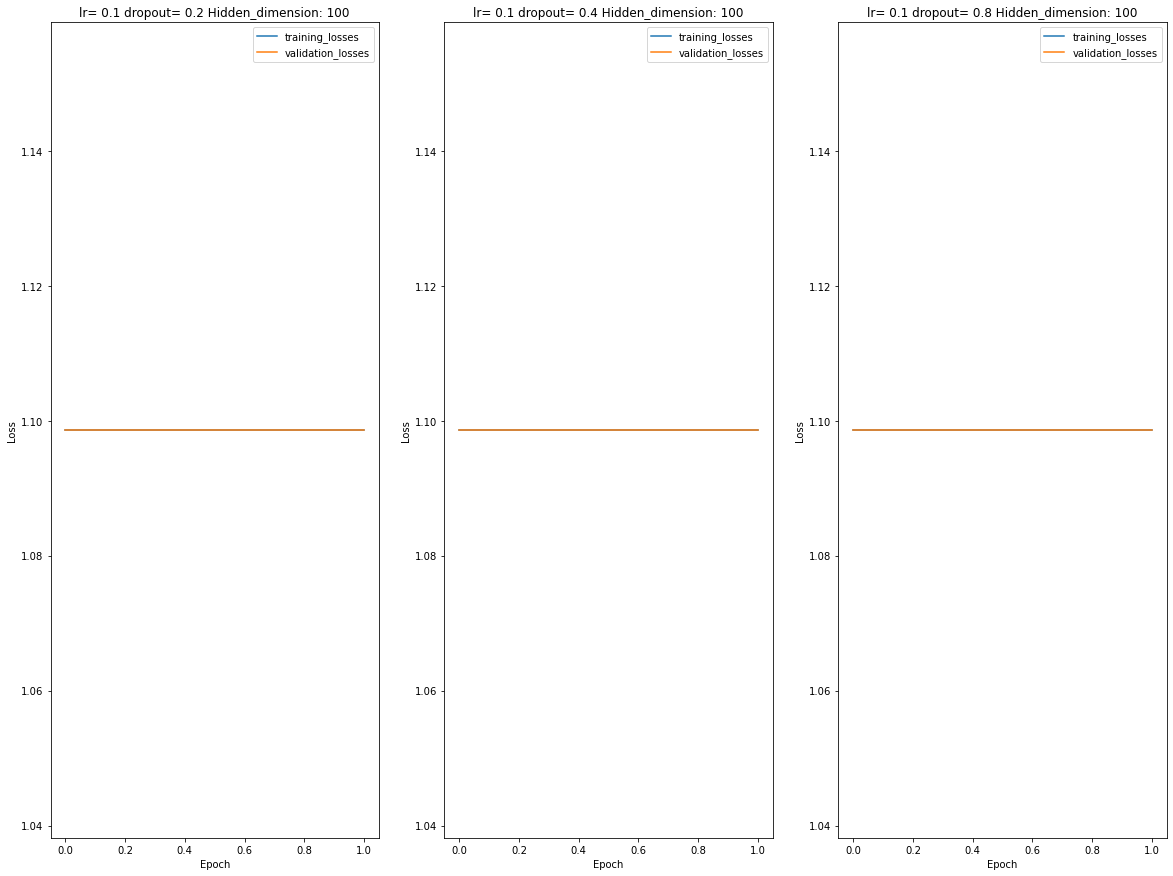

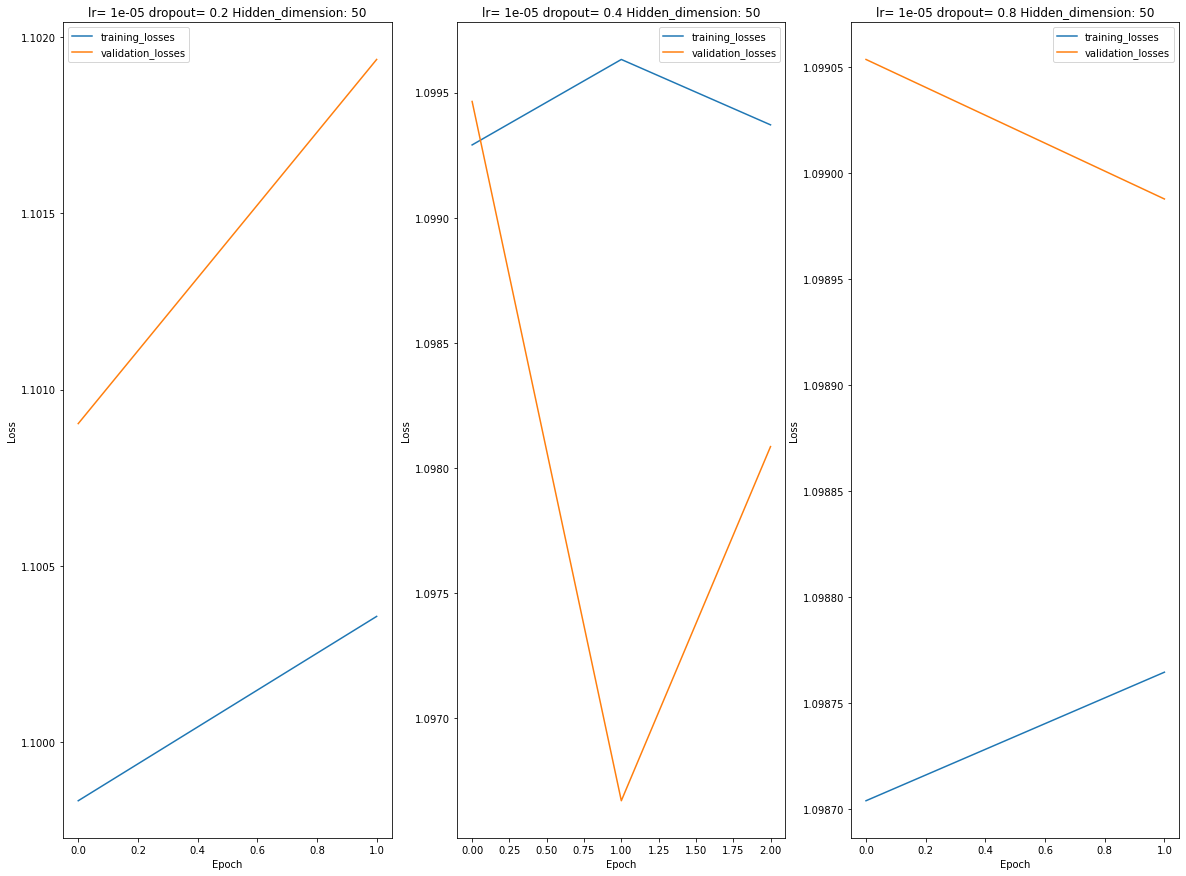

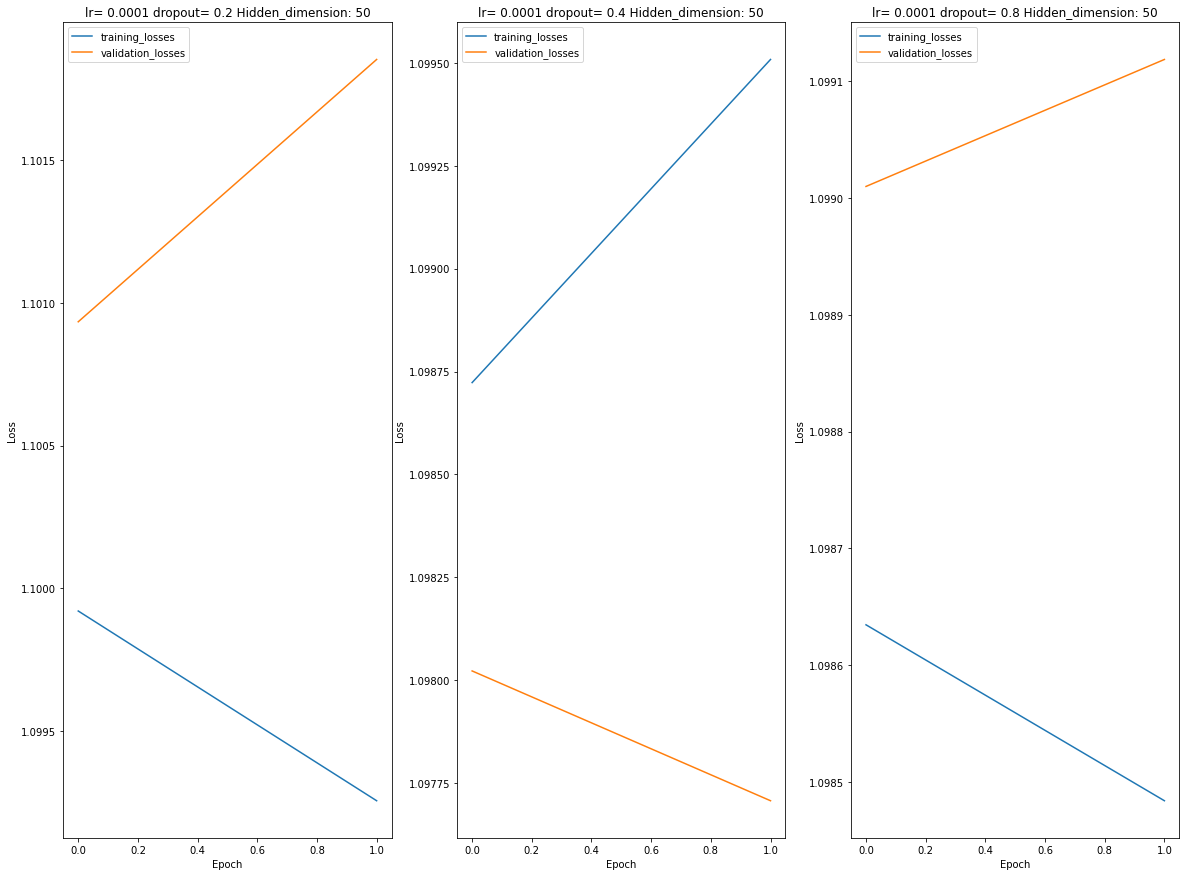

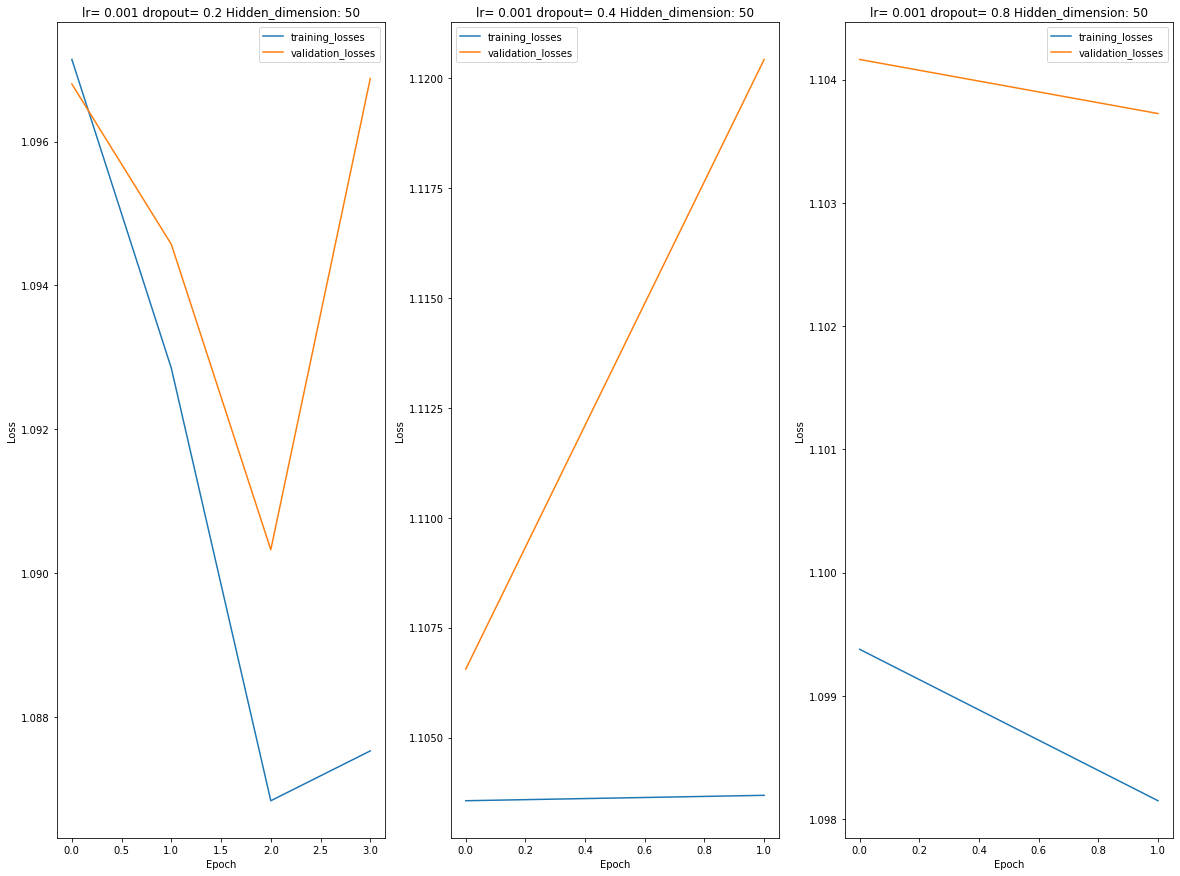

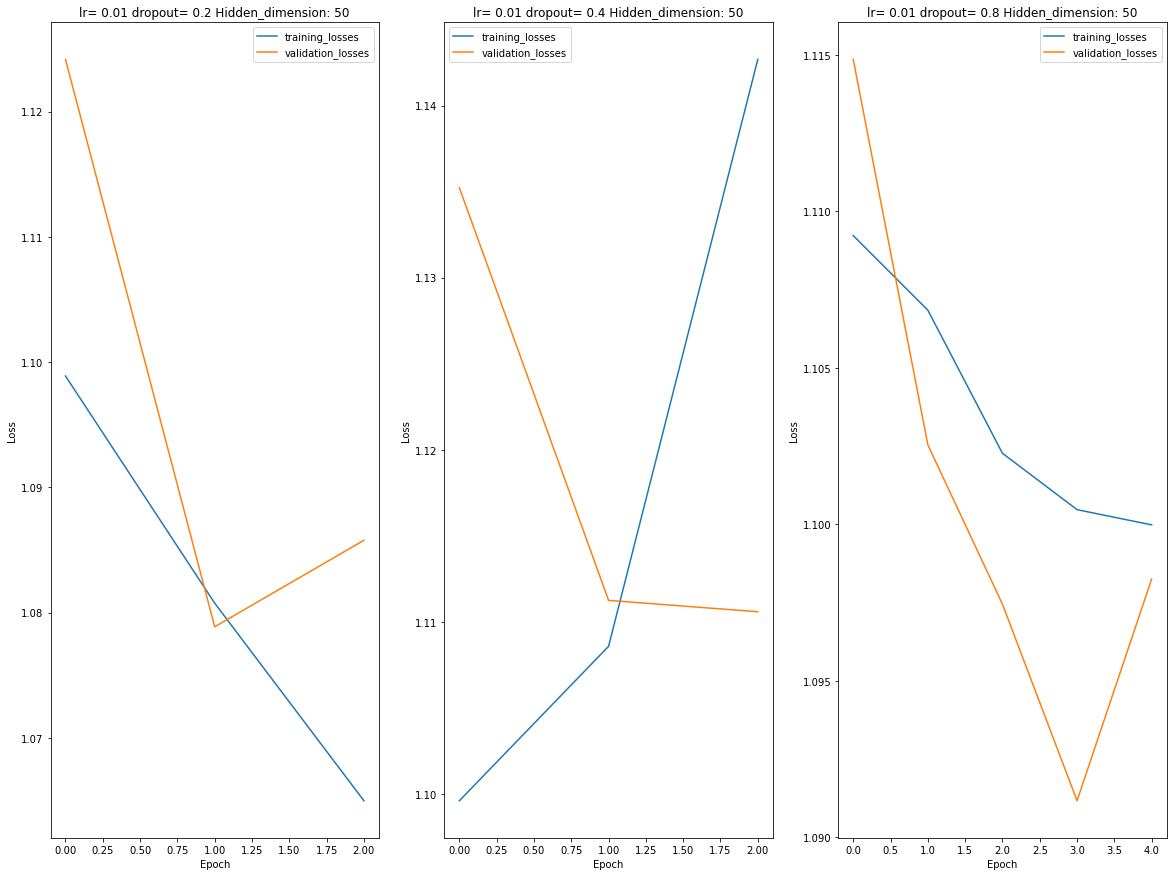

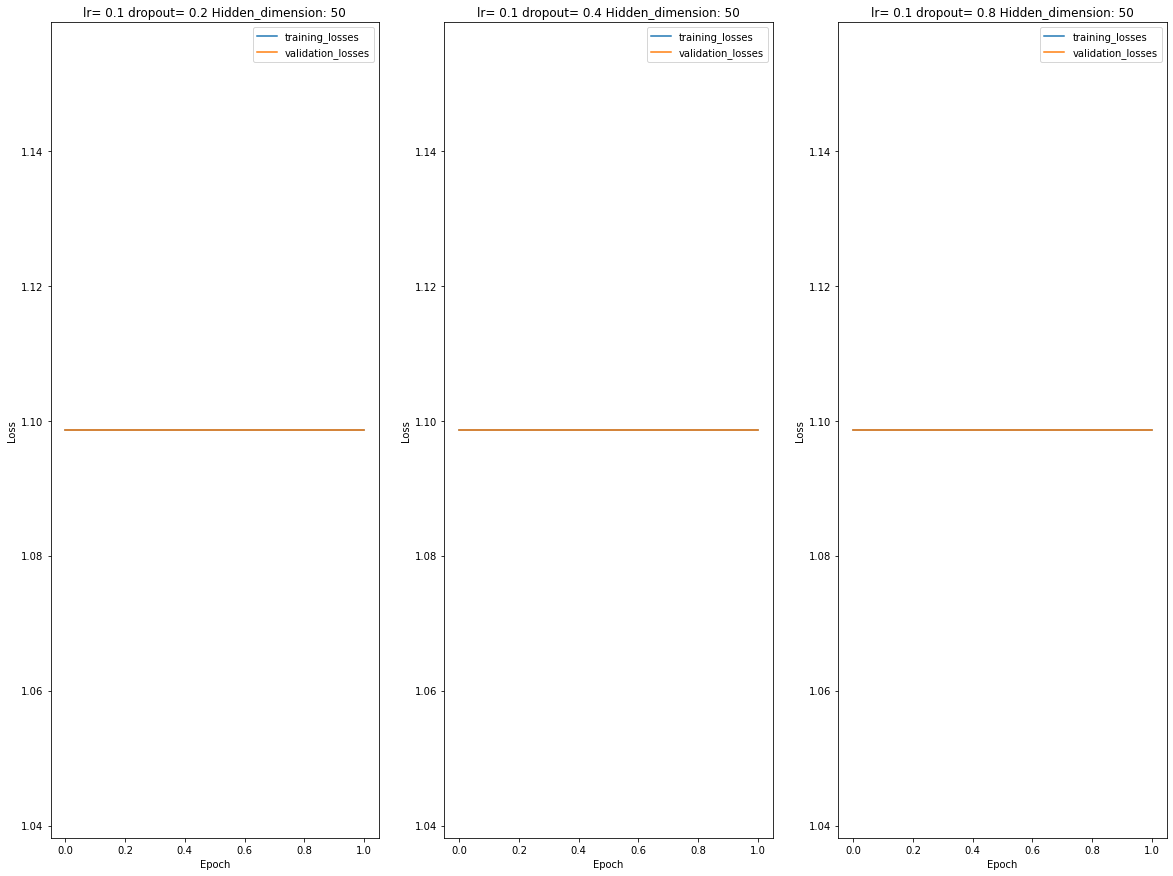

In [1201]:
#Calling the hyperparameter_tuning function to tune hyperparameters
best_lr, best_dropout, best_dim = hyperparameter_tuning(train_idx, train_labels, w_glove, val_idx, val_labels, 20)

In [1198]:
np.random.seed(123)
W = network_weights(vocab_size=len(w_glove),embedding_dim=300,hidden_dim=[best_dim], num_classes=3) 
W[0] = w_glove
W, loss_tr, dev_loss = SGD(train_idx, train_labels,
                            W,
                            X_dev=val_idx, 
                            Y_dev=val_labels,
                            lr=best_lr, 
                            dropout=best_dropout,
                            freeze_emb=True,
                            tolerance=0.001,
                            epochs=50)

Epoch =  0
Training_loss : 0.9860259252367072
Validation_loss : 1.030563480691505


In [1200]:
np.random.seed(123)
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['p']) 
            for x,y in zip(test_idx,test_true_labels)]

print('Accuracy:', accuracy_score(test_true_labels,preds_te))
print('Precision:', precision_score(test_true_labels,preds_te,average='macro'))
print('Recall:', recall_score(test_true_labels,preds_te,average='macro'))
print('F1-Score:', f1_score(test_true_labels,preds_te,average='macro'))

Accuracy: 0.5955555555555555
Precision: 0.7802583076965717
Recall: 0.5955555555555555
F1-Score: 0.5403438965243592


## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  |   86.9|  87.0 | 86.9 | 87.0  |
| Average Embedding (Pre-trained)  |  86.9 | 86.7  | 86.6  | 86.7  |
| Average Embedding (Pre-trained) + X hidden layers    |78.0   |  59.5 |  59.5 | 78.0  |


Please discuss why your best performing model is better than the rest.

According to the metrics shown above, our best performing model is Average embedding with the highest accuracy and highest F1 score where we have used one hot encoded vectors to generate the embeddings. Though the difference in the performance of average embedding and pre-trained is not very high. The worst performing model is the one with more hidden layers where we have added one more hidden layer and it gives the accuracy as 78%. 